# Prediksi Nilai NO2 Satu Hari Kedepan dengan KNN Regression (Lag 2)

**Tujuan**: Memprediksi nilai NO₂ satu hari ke depan menggunakan KNN Regression dengan 5 lagged features dan membandingkan dengan standar WHO

**Lokasi**: Bangkalan, Madura

**Data Source**: Sentinel-5P (Copernicus Data Space)

**Metode**: 
1. KNN Regression untuk prediksi nilai kontinyu (5 lag features)
2. Perbandingan dengan standar WHO (10 µg/m³ annual, 25 µg/m³ 24-hour)

**Periode**: Juni 2020 - Juni 2021

---

##  Standar WHO untuk NO₂

**World Health Organization (WHO)** menetapkan ambang batas konsentrasi Nitrogen Dioxide (NO₂) untuk kesehatan:

### Pedoman WHO untuk NO₂:
- **Rata-rata Tahunan (Annual Mean)**: Tidak melebihi **10 µg/m³**
- **Rata-rata 24 Jam**: Tidak melebihi **25 µg/m³**

### Konversi Unit:
Data Sentinel-5P menggunakan satuan **mol/m²** (kolom densitas vertikal), sedangkan WHO menggunakan **µg/m³** (konsentrasi permukaan).

### Konversi Sederhana (Aproksimasi):
Untuk konversi mol/m² ke µg/m³ (menggunakan ketinggian mixing layer ~1000m):

```
µg/m³ ≈ (mol/m² × Molar Mass × 10⁶) / Mixing Layer Height
µg/m³ ≈ (mol/m² × 46.01 g/mol × 10⁶ µg/g) / 1000 m
µg/m³ ≈ mol/m² × 46010
```

**Catatan**: Ini adalah konversi sederhana. Untuk hasil akurat, diperlukan data profil atmosfer dan mixing layer height yang sebenarnya.

### Interpretasi:
- **Model ini menggunakan regresi** untuk memprediksi nilai NO₂ dalam mol/m²
- Hasil prediksi akan **dibandingkan dengan standar WHO** (setelah konversi)
- Fokus pada **analisis nilai** dan **tren**, bukan klasifikasi binary

---

## Import Libraries

In [1]:
import openeo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, ConfusionMatrixDisplay
)

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Semua library berhasil diimport")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

---

# DATA UNDERSTANDING

**Data Understanding** adalah tahap untuk memahami karakteristik dan kualitas data sebelum melakukan analisis.

## Yang Dilakukan dalam Tahap Ini:

1. **Mengumpulkan Data** dari Sentinel-5P (satelit pemantau polusi udara)
2. **Mengeksplorasi Struktur Data**: Melihat jumlah baris, kolom, tipe data
3. **Statistik Deskriptif**: Mean, std, min, max dari NO₂
4. **Visualisasi Time Series**: Melihat pola dan trend data NO₂
5. **Deteksi Missing Values**: Mengidentifikasi data yang hilang
6. **Analisis Distribusi**: Memahami sebaran nilai NO₂

**Output**: Pemahaman tentang data NO₂ Bangkalan periode Juni 2020 - Juni 2021

---



## LANGKAH 1: Pengumpulan Data (Data Collection)

**Kategori: DATA UNDERSTANDING**

**Sumber**: Sentinel-5P via OpenEO (Copernicus Data Space)

**Output**: CSV dengan data NO₂ harian untuk periode Juni 2020 - Juni 2021

**Tujuan**:
- Mengumpulkan data time series NO₂ dari satelit
- Memahami struktur dan format data
- Menyimpan data mentah untuk analisis lanjutan

In [9]:
print("="*70)
print("LANGKAH 1: PENGUMPULAN DATA ")
print("="*70)

# Nama file CSV output
csv_filename = "timeseries.csv"

# CEK APAKAH FILE CSV SUDAH ADA
if os.path.exists(csv_filename):
    print(f"\n[INFO] File '{csv_filename}' sudah ada!")
    print("[INFO] Loading data dari file CSV yang tersimpan...")
    print("[INFO] Tidak perlu melakukan crawling ulang.\n")
    
    # Load data dari CSV yang sudah ada
    df = pd.read_csv(csv_filename)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    
    print(f"[SUCCESS] Data berhasil di-load dari file lokal")
    print(f"  - Total records: {len(df)}")
    print(f"  - Periode: {df['date'].min()} hingga {df['date'].max()}")
    print(f"  - File: {csv_filename}")
    print(f"\nData pertama (5 baris):")
    print(df.head())
    
else:
    print(f"\n[INFO] File '{csv_filename}' tidak ditemukan.")
    print("[INFO] Memulai proses crawling data dari Sentinel-5P...")
    print("[INFO] Proses ini hanya dilakukan sekali.\n")
    
    try:
        # 1. Koneksi ke Copernicus Data Space
        print("[KONEKSI] Menghubungkan ke Copernicus Data Space...")
        connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
        print("[KONEKSI] Berhasil terhubung dan terautentikasi!\n")

        # 2. Area of Interest (AOI) - Bangkalan, Madura
        aoi = {
            "type": "Polygon",
            "coordinates": [
                [
                    [112.65, -7.21],
                    [112.65, -7.34],
                    [112.80, -7.34],
                    [112.87, -7.21],
                    [112.65, -7.21],
                ]
            ],
        }

        # 3. Load data Sentinel-5P
        print("[PROSES] Loading collection Sentinel-5P...")
        s5p = connection.load_collection(
            "SENTINEL_5P_L2",
            spatial_extent={
                "west": 112.72456356837233,
                "south": -7.064639201806031,
                "east": 112.77959573996094,
                "north": -7.026115991674629,
            },
            temporal_extent=["2020-06-01", "2021-06-30"],
            bands=["NO2"],
        )

        # 4. Mask nilai negatif
        def mask_invalid(x):
            return x < 0

        s5p_masked = s5p.mask(s5p.apply(mask_invalid))

        # 5. Agregasi temporal (harian)
        print("[PROSES] Agregasi temporal (harian)...")
        daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

        # 6. Agregasi spasial (mean dalam AOI)
        print("[PROSES] Agregasi spasial (mean dalam AOI)...")
        daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

        # 7. Jalankan batch job
        print("[PROSES] Mengirim batch job ke OpenEO...")
        job = daily_mean_aoi.execute_batch(out_format="CSV")
        print("\n[CRAWLING] Menunggu job OpenEO selesai...")

        while True:
            status = job.describe()["status"]
            print(f"[CRAWLING] Status: {status}")
            if status == "finished":
                break
            elif status == "error":
                raise RuntimeError("Job gagal")
            time.sleep(15)

        # 8. Unduh hasil
        print("\n[DOWNLOAD] Mengunduh hasil...")
        results = job.get_results()
        results.download_files("no2_results")

        # 9. Baca file CSV
        csv_files = [f for f in os.listdir("no2_results") if f.endswith(".csv")]
        df = pd.read_csv(os.path.join("no2_results", csv_files[0]))

        # 10. Data preprocessing dan SIMPAN ke CSV
        df["date"] = pd.to_datetime(df["date"])
        df = df.sort_values("date").reset_index(drop=True)
        df.to_csv(csv_filename, index=False)

        print(f"\n[SUCCESS] Data berhasil dikumpulkan dan disimpan")
        print(f"  - Total records: {len(df)}")
        print(f"  - Periode: {df['date'].min()} hingga {df['date'].max()}")
        print(f"  - File: {csv_filename}")
        print(f"\n[INFO] File '{csv_filename}' telah disimpan.")
        print(f"[INFO] Eksekusi berikutnya akan menggunakan file ini tanpa crawling ulang.")
        print(f"\nData pertama (5 baris):")
        print(df.head())
        
    except Exception as e:
        print(f"\n[ERROR] Terjadi kesalahan saat crawling data!")
        print(f"[ERROR] Jenis error: {type(e).__name__}")
        print(f"[ERROR] Pesan: {str(e)}\n")
        
        print("[SOLUSI] Beberapa opsi untuk mengatasi masalah ini:")
        print("1. Coba jalankan ulang sel ini (token mungkin expired)")
        print("2. Restart kernel dan jalankan dari awal")
        print("3. Gunakan data yang sudah tersimpan (jika pernah berhasil crawling)")
        print("4. Periksa koneksi internet Anda")
        print("5. Periksa status layanan OpenEO: https://openeo.dataspace.copernicus.eu/")
        
        # Cek apakah ada backup data
        if os.path.exists("no2_results"):
            backup_files = [f for f in os.listdir("no2_results") if f.endswith(".csv")]
            if backup_files:
                print(f"\n[INFO] Ditemukan backup data di folder 'no2_results'")
                print(f"[INFO] Mencoba load dari backup...")
                try:
                    df = pd.read_csv(os.path.join("no2_results", backup_files[0]))
                    df["date"] = pd.to_datetime(df["date"])
                    df = df.sort_values("date").reset_index(drop=True)
                    df.to_csv(csv_filename, index=False)
                    print(f"[SUCCESS] Data berhasil di-load dari backup!")
                    print(f"  - Total records: {len(df)}")
                    print(f"  - File: {csv_filename}")
                except Exception as backup_error:
                    print(f"[ERROR] Gagal load backup: {str(backup_error)}")
                    raise
            else:
                raise
        else:
            raise

LANGKAH 1: PENGUMPULAN DATA 

[INFO] File 'timeseries.csv' sudah ada!
[INFO] Loading data dari file CSV yang tersimpan...
[INFO] Tidak perlu melakukan crawling ulang.

[SUCCESS] Data berhasil di-load dari file lokal
  - Total records: 395
  - Periode: 2020-06-01 00:00:00 hingga 2021-06-30 00:00:00
  - File: timeseries.csv

Data pertama (5 baris):
        date       NO2    month
0 2020-06-01  0.000035  2020-06
1 2020-06-02  0.000032  2020-06
2 2020-06-03  0.000032  2020-06
3 2020-06-04  0.000032  2020-06
4 2020-06-05  0.000286  2020-06


# DATA PREPARATION

Tahap persiapan data untuk machine learning:
1. **Missing Values**: Interpolasi linear
2. **Supervised Learning**: Membuat lag features 
3. **Train-Test Split**: 80-20 split
4. **Normalisasi**: MinMaxScaler untuk KNN



## LANGKAH 2: Preprocessing Missing Values

Interpolasi linear untuk menangani missing values dalam data time series.

LANGKAH 2: INTERPOLASI MISSING VALUES
Missing values: 0 → 0
Data shape: (395, 3) | Range: [0.00000309, 0.00028601]


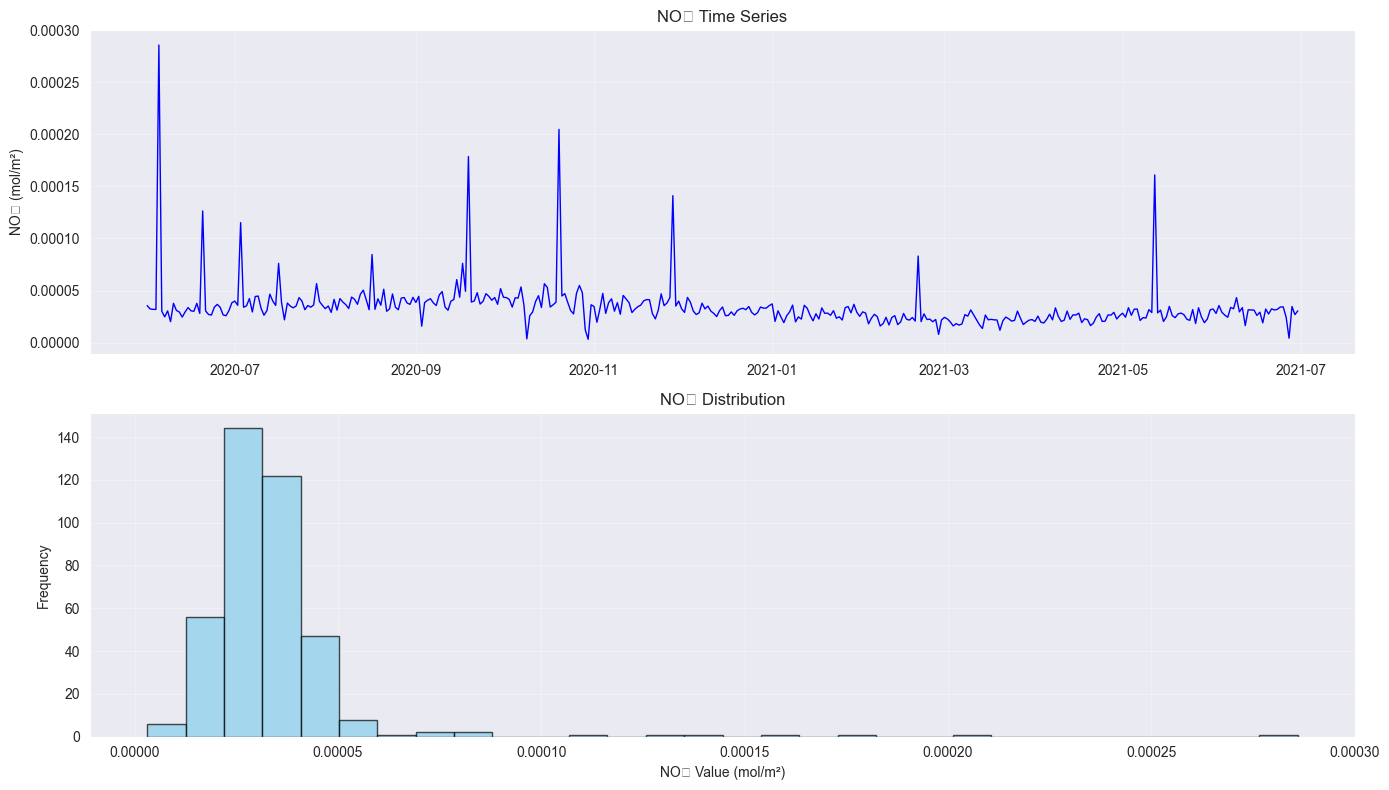

Preprocessing completed.


In [10]:
# LANGKAH 2: PREPROCESSING MISSING VALUES
print("=" * 50)
print("LANGKAH 2: INTERPOLASI MISSING VALUES")
print("=" * 50)

# Load dan preprocessing data
df = pd.read_csv("timeseries.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# Handle missing values
missing_before = df["NO2"].isna().sum()
df["NO2"] = df["NO2"].interpolate(method="linear").fillna(method="bfill").fillna(method="ffill")
missing_after = df["NO2"].isna().sum()

print(f"Missing values: {missing_before} → {missing_after}")
print(f"Data shape: {df.shape} | Range: [{df['NO2'].min():.8f}, {df['NO2'].max():.8f}]")

# Visualisasi
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

ax1.plot(df["date"], df["NO2"], color="blue", linewidth=1)
ax1.set_title("NO₂ Time Series")
ax1.set_ylabel("NO₂ (mol/m²)")
ax1.grid(True, alpha=0.3)

ax2.hist(df["NO2"], bins=30, edgecolor="black", alpha=0.7, color="skyblue")
ax2.set_title("NO₂ Distribution")
ax2.set_xlabel("NO₂ Value (mol/m²)")
ax2.set_ylabel("Frequency")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Preprocessing completed.")

## LANGKAH 2.1: Deteksi dan Analisis Outlier

**Kategori: DATA QUALITY ASSESSMENT**

Deteksi outlier menggunakan berbagai metode:
1. **IQR Method**: Menggunakan Interquartile Range
2. **Z-Score Method**: Menggunakan standar deviasi
3. **Isolation Forest**: Metode ensemble untuk deteksi anomali
4. **Visualisasi**: Boxplot dan scatter plot untuk identifikasi outlier

**Tujuan**: 
- Mengidentifikasi nilai NO₂ yang tidak normal
- Memahami distribusi data dan kemungkinan kesalahan pengukuran
- Memberikan informasi untuk preprocessing lanjutan

In [11]:
# LANGKAH 2.1: DETEKSI DAN ANALISIS OUTLIER
print("=" * 60)
print("LANGKAH 2.1: DETEKSI DAN ANALISIS OUTLIER")
print("=" * 60)

from sklearn.ensemble import IsolationForest
from scipy import stats

# Pastikan data sudah di-load
NO2_data = df["NO2"].values.reshape(-1, 1)
NO2_series = df["NO2"]

print(f"Data untuk analisis outlier:")
print(f"- Total data points: {len(NO2_series)}")
print(f"- Range: [{NO2_series.min():.8f}, {NO2_series.max():.8f}]")
print(f"- Mean: {NO2_series.mean():.8f}")
print(f"- Std: {NO2_series.std():.8f}")

# =============================================================================
# METHOD 1: IQR METHOD (Interquartile Range)
# =============================================================================
print(f"\n{'='*50}")
print("METHOD 1: IQR METHOD")
print(f"{'='*50}")

Q1 = NO2_series.quantile(0.25)
Q3 = NO2_series.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = (NO2_series < lower_bound) | (NO2_series > upper_bound)
iqr_outlier_count = iqr_outliers.sum()

print(f"IQR Statistics:")
print(f"- Q1 (25%): {Q1:.8f}")
print(f"- Q3 (75%): {Q3:.8f}")
print(f"- IQR: {IQR:.8f}")
print(f"- Lower bound: {lower_bound:.8f}")
print(f"- Upper bound: {upper_bound:.8f}")
print(f"- Outliers detected: {iqr_outlier_count} ({iqr_outlier_count/len(NO2_series)*100:.2f}%)")

if iqr_outlier_count > 0:
    outlier_values = NO2_series[iqr_outliers]
    print(f"- Outlier range: [{outlier_values.min():.8f}, {outlier_values.max():.8f}]")

# =============================================================================
# METHOD 2: Z-SCORE METHOD
# =============================================================================
print(f"\n{'='*50}")
print("METHOD 2: Z-SCORE METHOD")
print(f"{'='*50}")

z_scores = np.abs(stats.zscore(NO2_series))
z_threshold = 3  # Standard threshold for outliers
zscore_outliers = z_scores > z_threshold
zscore_outlier_count = zscore_outliers.sum()

print(f"Z-Score Statistics:")
print(f"- Threshold: {z_threshold}")
print(f"- Max Z-score: {z_scores.max():.4f}")
print(f"- Outliers detected: {zscore_outlier_count} ({zscore_outlier_count/len(NO2_series)*100:.2f}%)")

if zscore_outlier_count > 0:
    outlier_z_values = NO2_series[zscore_outliers]
    outlier_z_scores = z_scores[zscore_outliers]
    print(f"- Outlier Z-scores range: [{outlier_z_scores.min():.4f}, {outlier_z_scores.max():.4f}]")
    print(f"- Outlier values range: [{outlier_z_values.min():.8f}, {outlier_z_values.max():.8f}]")

# =============================================================================
# METHOD 3: ISOLATION FOREST
# =============================================================================
print(f"\n{'='*50}")
print("METHOD 3: ISOLATION FOREST")
print(f"{'='*50}")

# Isolation Forest untuk deteksi anomali
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
isolation_outliers = iso_forest.fit_predict(NO2_data) == -1
isolation_outlier_count = isolation_outliers.sum()

print(f"Isolation Forest Statistics:")
print(f"- Contamination rate: 10%")
print(f"- Outliers detected: {isolation_outlier_count} ({isolation_outlier_count/len(NO2_series)*100:.2f}%)")

if isolation_outlier_count > 0:
    outlier_iso_values = NO2_series[isolation_outliers]
    print(f"- Outlier range: [{outlier_iso_values.min():.8f}, {outlier_iso_values.max():.8f}]")

# =============================================================================
# COMPREHENSIVE OUTLIER SUMMARY
# =============================================================================
print(f"\n{'='*60}")
print("COMPREHENSIVE OUTLIER SUMMARY")
print(f"{'='*60}")

# Combine all methods
all_outliers = iqr_outliers | zscore_outliers | isolation_outliers
total_unique_outliers = all_outliers.sum()

print(f"Outlier Detection Summary:")
print(f"- IQR Method: {iqr_outlier_count} outliers")
print(f"- Z-Score Method: {zscore_outlier_count} outliers")
print(f"- Isolation Forest: {isolation_outlier_count} outliers")
print(f"- Combined (unique): {total_unique_outliers} outliers ({total_unique_outliers/len(NO2_series)*100:.2f}%)")

# Detailed outlier analysis
if total_unique_outliers > 0:
    outlier_indices = df[all_outliers].index.tolist()
    outlier_dates = df.loc[all_outliers, 'date'].tolist()
    outlier_values = df.loc[all_outliers, 'NO2'].tolist()
    
    print(f"\nDetailed Outlier Information:")
    print(f"- Outlier indices: {outlier_indices[:10]}{'...' if len(outlier_indices) > 10 else ''}")
    print(f"- Date range: {min(outlier_dates)} to {max(outlier_dates)}")
    print(f"- Value range: [{min(outlier_values):.8f}, {max(outlier_values):.8f}]")

print(f"\n{'='*60}")
print("OUTLIER DETECTION COMPLETED")
print(f"{'='*60}")

LANGKAH 2.1: DETEKSI DAN ANALISIS OUTLIER
Data untuk analisis outlier:
- Total data points: 395
- Range: [0.00000309, 0.00028601]
- Mean: 0.00003394
- Std: 0.00002251

METHOD 1: IQR METHOD
IQR Statistics:
- Q1 (25%): 0.00002465
- Q3 (75%): 0.00003703
- IQR: 0.00001238
- Lower bound: 0.00000608
- Upper bound: 0.00005559
- Outliers detected: 17 (4.30%)
- Outlier range: [0.00000309, 0.00028601]

METHOD 2: Z-SCORE METHOD
Z-Score Statistics:
- Threshold: 3
- Max Z-score: 11.2140
- Outliers detected: 7 (1.77%)
- Outlier Z-scores range: [3.6169, 11.2140]
- Outlier values range: [0.00011524, 0.00028601]

METHOD 3: ISOLATION FOREST
Isolation Forest Statistics:
- Contamination rate: 10%
- Outliers detected: 40 (10.13%)
- Outlier range: [0.00000309, 0.00028601]

COMPREHENSIVE OUTLIER SUMMARY
Outlier Detection Summary:
- IQR Method: 17 outliers
- Z-Score Method: 7 outliers
- Isolation Forest: 40 outliers
- Combined (unique): 40 outliers (10.13%)

Detailed Outlier Information:
- Outlier indices: [4

VISUALISASI OUTLIER DETECTION


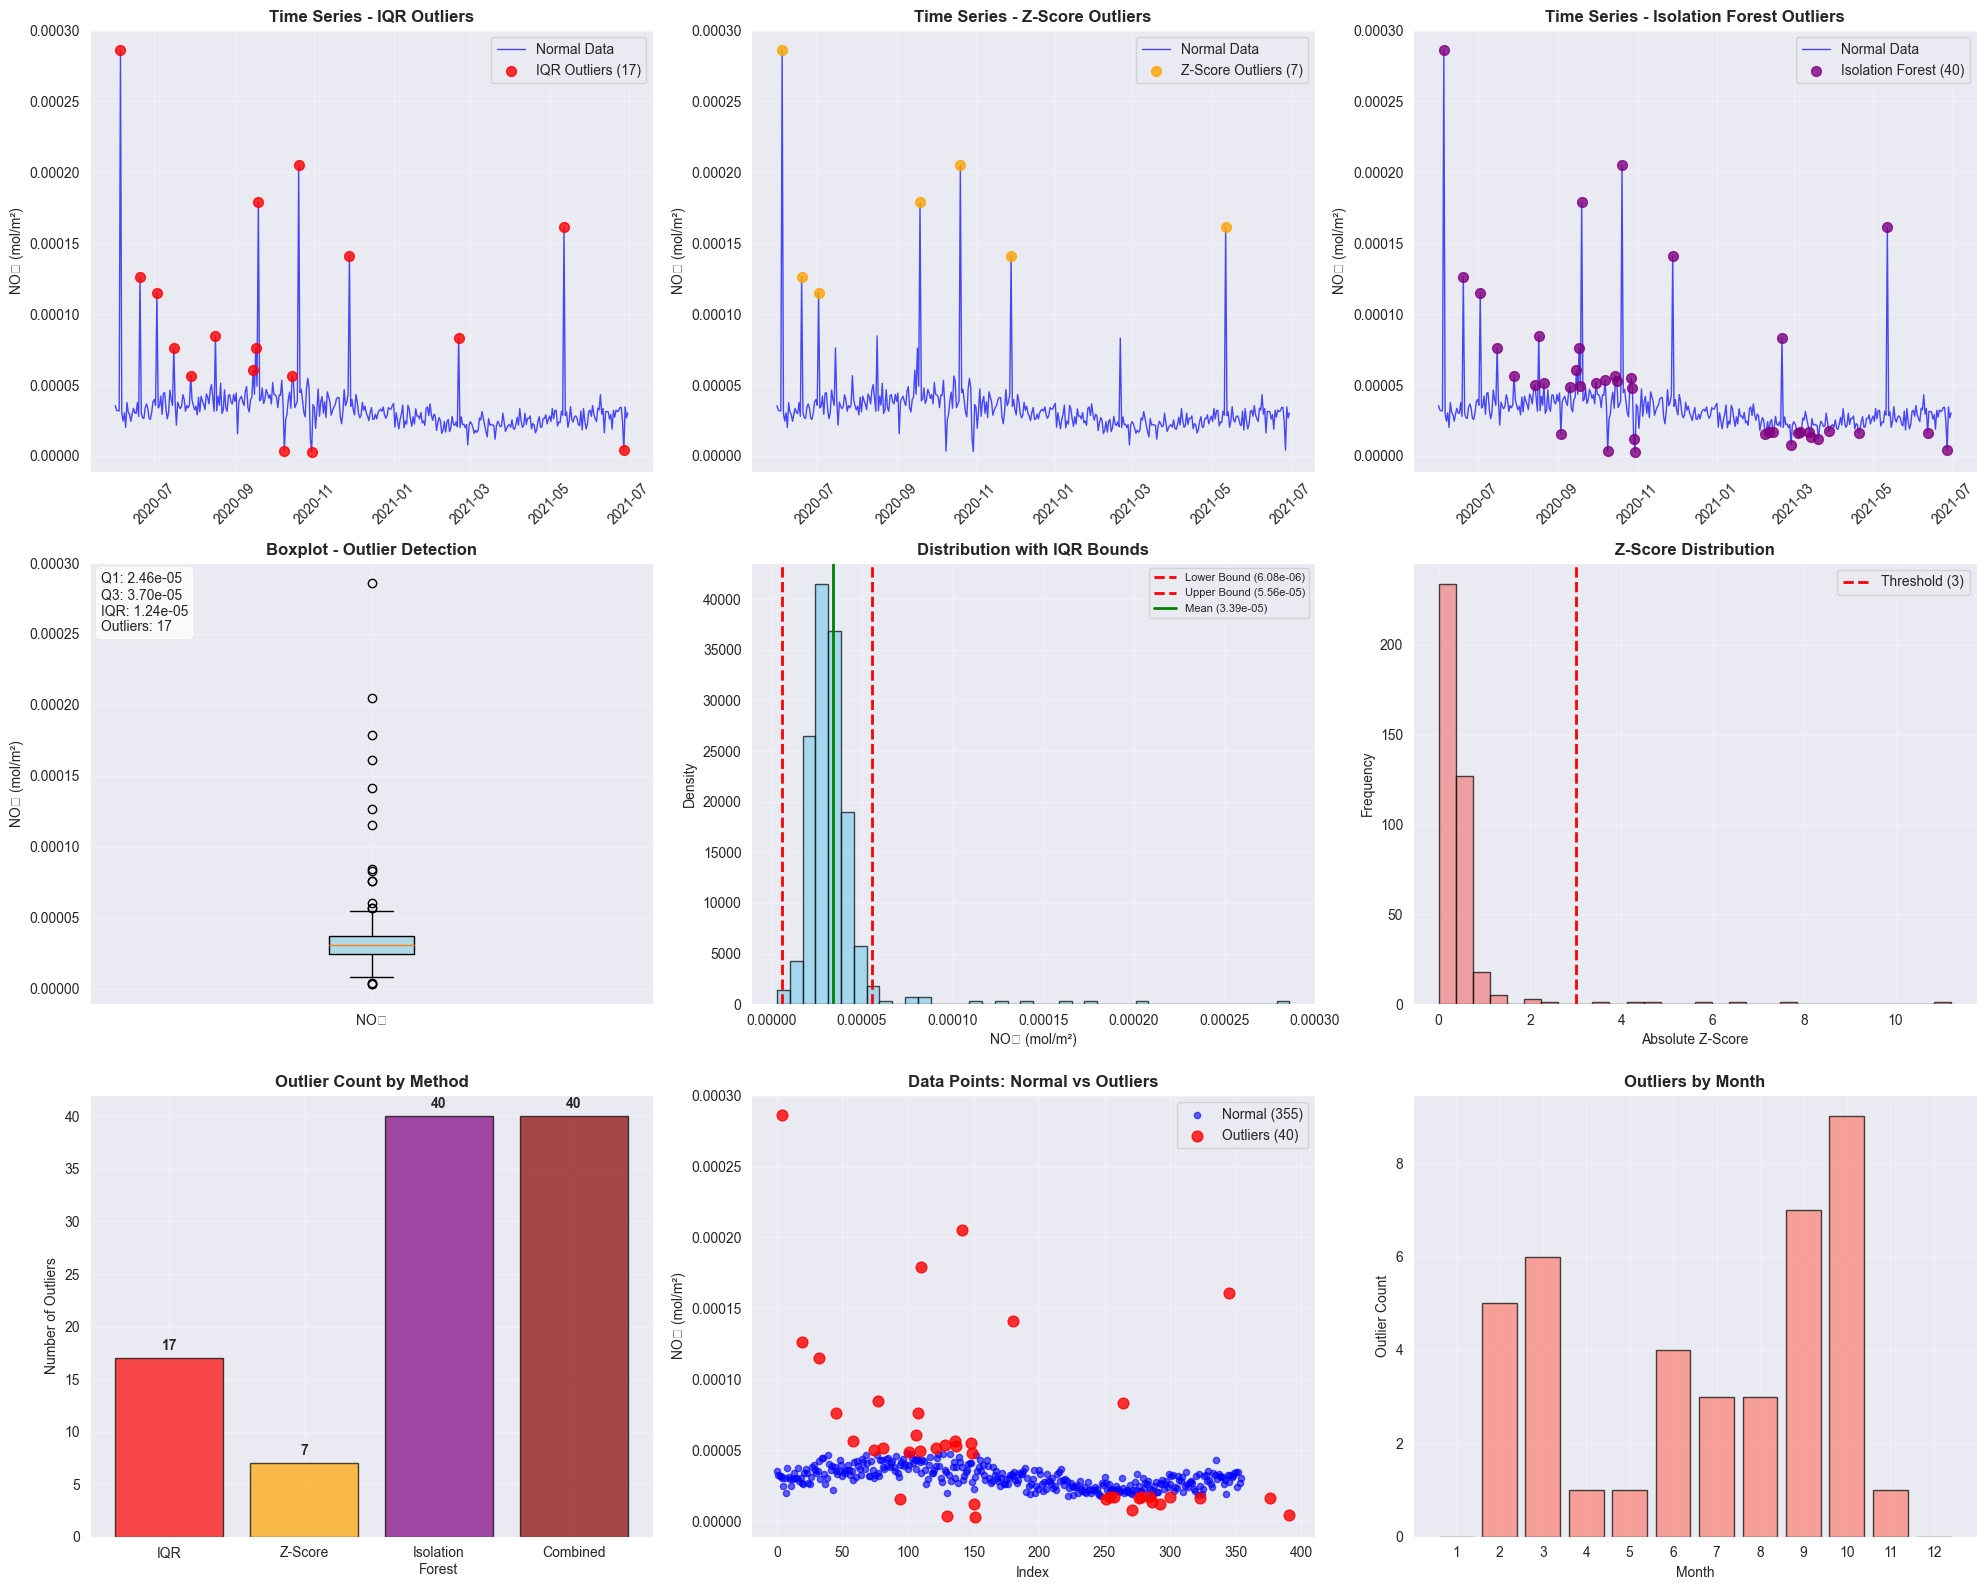


OUTLIER TREATMENT RECOMMENDATIONS
Recommendation: HIGH OUTLIER RATE - Requires attention
Suggested Treatment: Investigate data quality, consider outlier removal or transformation
Outlier Rate: 10.13%

[INFO] Outlier detection completed successfully!
[INFO] Outlier information saved for preprocessing decisions.


In [12]:
# VISUALISASI OUTLIER DETECTION
print("=" * 60)
print("VISUALISASI OUTLIER DETECTION")
print("=" * 60)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))

# =============================================================================
# PLOT 1: TIME SERIES DENGAN OUTLIER HIGHLIGHTING
# =============================================================================
ax1 = plt.subplot(3, 3, 1)
ax1.plot(df["date"], df["NO2"], color="blue", alpha=0.7, linewidth=1, label="Normal Data")
if iqr_outlier_count > 0:
    ax1.scatter(df.loc[iqr_outliers, "date"], df.loc[iqr_outliers, "NO2"], 
                color="red", s=50, alpha=0.8, label=f"IQR Outliers ({iqr_outlier_count})", zorder=5)
ax1.set_title("Time Series - IQR Outliers", fontsize=12, fontweight='bold')
ax1.set_ylabel("NO₂ (mol/m²)")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# =============================================================================
# PLOT 2: TIME SERIES DENGAN Z-SCORE OUTLIERS
# =============================================================================
ax2 = plt.subplot(3, 3, 2)
ax2.plot(df["date"], df["NO2"], color="blue", alpha=0.7, linewidth=1, label="Normal Data")
if zscore_outlier_count > 0:
    ax2.scatter(df.loc[zscore_outliers, "date"], df.loc[zscore_outliers, "NO2"], 
                color="orange", s=50, alpha=0.8, label=f"Z-Score Outliers ({zscore_outlier_count})", zorder=5)
ax2.set_title("Time Series - Z-Score Outliers", fontsize=12, fontweight='bold')
ax2.set_ylabel("NO₂ (mol/m²)")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# =============================================================================
# PLOT 3: TIME SERIES DENGAN ISOLATION FOREST OUTLIERS
# =============================================================================
ax3 = plt.subplot(3, 3, 3)
ax3.plot(df["date"], df["NO2"], color="blue", alpha=0.7, linewidth=1, label="Normal Data")
if isolation_outlier_count > 0:
    ax3.scatter(df.loc[isolation_outliers, "date"], df.loc[isolation_outliers, "NO2"], 
                color="purple", s=50, alpha=0.8, label=f"Isolation Forest ({isolation_outlier_count})", zorder=5)
ax3.set_title("Time Series - Isolation Forest Outliers", fontsize=12, fontweight='bold')
ax3.set_ylabel("NO₂ (mol/m²)")
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# =============================================================================
# PLOT 4: BOXPLOT UNTUK DETEKSI VISUAL OUTLIERS
# =============================================================================
ax4 = plt.subplot(3, 3, 4)
box_plot = ax4.boxplot(df["NO2"], patch_artist=True, labels=["NO₂"])
box_plot['boxes'][0].set_facecolor('lightblue')
ax4.set_title("Boxplot - Outlier Detection", fontsize=12, fontweight='bold')
ax4.set_ylabel("NO₂ (mol/m²)")
ax4.grid(True, alpha=0.3)

# Add statistics text
stats_text = f"Q1: {Q1:.2e}\nQ3: {Q3:.2e}\nIQR: {IQR:.2e}\nOutliers: {iqr_outlier_count}"
ax4.text(0.02, 0.98, stats_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# =============================================================================
# PLOT 5: HISTOGRAM DENGAN OUTLIER BOUNDARIES
# =============================================================================
ax5 = plt.subplot(3, 3, 5)
ax5.hist(df["NO2"], bins=40, alpha=0.7, color="skyblue", edgecolor="black", density=True)
ax5.axvline(lower_bound, color="red", linestyle="--", linewidth=2, label=f"Lower Bound ({lower_bound:.2e})")
ax5.axvline(upper_bound, color="red", linestyle="--", linewidth=2, label=f"Upper Bound ({upper_bound:.2e})")
ax5.axvline(NO2_series.mean(), color="green", linestyle="-", linewidth=2, label=f"Mean ({NO2_series.mean():.2e})")
ax5.set_title("Distribution with IQR Bounds", fontsize=12, fontweight='bold')
ax5.set_xlabel("NO₂ (mol/m²)")
ax5.set_ylabel("Density")
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# =============================================================================
# PLOT 6: Z-SCORE DISTRIBUTION
# =============================================================================
ax6 = plt.subplot(3, 3, 6)
ax6.hist(z_scores, bins=30, alpha=0.7, color="lightcoral", edgecolor="black")
ax6.axvline(z_threshold, color="red", linestyle="--", linewidth=2, label=f"Threshold ({z_threshold})")
ax6.set_title("Z-Score Distribution", fontsize=12, fontweight='bold')
ax6.set_xlabel("Absolute Z-Score")
ax6.set_ylabel("Frequency")
ax6.legend()
ax6.grid(True, alpha=0.3)

# =============================================================================
# PLOT 7: OUTLIER COMPARISON VENN-STYLE BAR CHART
# =============================================================================
ax7 = plt.subplot(3, 3, 7)
methods = ['IQR', 'Z-Score', 'Isolation\nForest', 'Combined']
counts = [iqr_outlier_count, zscore_outlier_count, isolation_outlier_count, total_unique_outliers]
colors = ['red', 'orange', 'purple', 'darkred']

bars = ax7.bar(methods, counts, color=colors, alpha=0.7, edgecolor='black')
ax7.set_title("Outlier Count by Method", fontsize=12, fontweight='bold')
ax7.set_ylabel("Number of Outliers")
ax7.grid(True, alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, counts):
    ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontweight='bold')

# =============================================================================
# PLOT 8: OUTLIER VALUES SCATTER PLOT
# =============================================================================
ax8 = plt.subplot(3, 3, 8)
if total_unique_outliers > 0:
    normal_data = df[~all_outliers]
    outlier_data = df[all_outliers]
    
    ax8.scatter(range(len(normal_data)), normal_data["NO2"], 
                color="blue", alpha=0.6, s=20, label=f"Normal ({len(normal_data)})")
    ax8.scatter(outlier_data.index, outlier_data["NO2"], 
                color="red", s=60, alpha=0.8, label=f"Outliers ({total_unique_outliers})")
else:
    ax8.scatter(range(len(df)), df["NO2"], color="blue", alpha=0.6, s=20, label="All Normal")

ax8.set_title("Data Points: Normal vs Outliers", fontsize=12, fontweight='bold')
ax8.set_xlabel("Index")
ax8.set_ylabel("NO₂ (mol/m²)")
ax8.legend()
ax8.grid(True, alpha=0.3)

# =============================================================================
# PLOT 9: SEASONAL OUTLIER PATTERN
# =============================================================================
ax9 = plt.subplot(3, 3, 9)
df['month'] = df['date'].dt.month
monthly_outlier_count = df[all_outliers].groupby('month').size()
all_months = range(1, 13)
monthly_counts = [monthly_outlier_count.get(month, 0) for month in all_months]

ax9.bar(all_months, monthly_counts, color='salmon', alpha=0.7, edgecolor='black')
ax9.set_title("Outliers by Month", fontsize=12, fontweight='bold')
ax9.set_xlabel("Month")
ax9.set_ylabel("Outlier Count")
ax9.set_xticks(all_months)
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# OUTLIER TREATMENT RECOMMENDATION
# =============================================================================
print(f"\n{'='*60}")
print("OUTLIER TREATMENT RECOMMENDATIONS")
print(f"{'='*60}")

outlier_percentage = total_unique_outliers / len(NO2_series) * 100

if outlier_percentage < 5:
    recommendation = "LOW OUTLIER RATE - Keep outliers for model robustness"
    treatment = "No action required"
elif outlier_percentage < 10:
    recommendation = "MODERATE OUTLIER RATE - Consider investigation"
    treatment = "Investigate outlier patterns, consider capping extreme values"
else:
    recommendation = "HIGH OUTLIER RATE - Requires attention"
    treatment = "Investigate data quality, consider outlier removal or transformation"

print(f"Recommendation: {recommendation}")
print(f"Suggested Treatment: {treatment}")
print(f"Outlier Rate: {outlier_percentage:.2f}%")

# Save outlier information for later use
outlier_info = {
    'iqr_outliers': iqr_outliers,
    'zscore_outliers': zscore_outliers,
    'isolation_outliers': isolation_outliers,
    'combined_outliers': all_outliers,
    'outlier_percentage': outlier_percentage,
    'recommendation': recommendation
}

print(f"\n[INFO] Outlier detection completed successfully!")
print(f"[INFO] Outlier information saved for preprocessing decisions.")
print(f"{'='*60}")

## LANGKAH 2.2: Outlier Treatment (Opsional)

**Kategori: DATA PREPROCESSING**

Berdasarkan hasil deteksi outlier, berikut opsi treatment yang dapat dipilih:

1. **No Treatment**: Mempertahankan outlier untuk robustness model
2. **Winsorization**: Mengganti outlier dengan nilai percentile tertentu
3. **Capping**: Membatasi nilai ekstrem dengan threshold
4. **Removal**: Menghapus outlier dari dataset
5. **Transformation**: Log atau Box-Cox transformation

**Catatan**: Untuk time series, removal outlier dapat mengganggu kontinuitas temporal. Winsorization atau capping lebih disarankan.

LANGKAH 2.2: OUTLIER TREATMENT OPTIONS

Applying different outlier treatments:
1. No Treatment: 395 records maintained
2. Winsorization: Capped at [0.00001818, 0.00004953]
3. IQR Capping: Capped at [0.00000608, 0.00005559]
4. Log Transform: Applied log(x + 0.00000000)
5. Outlier Removal: 355 records remaining (40 removed)

TREATMENT COMPARISON
          Treatment  Count       Mean       Std        Min       Max  \
0          Original    395   0.000032  0.000010   0.000006  0.000056   
1        Winsorized    395   0.000032  0.000009   0.000018  0.000050   
2        IQR Capped    395   0.000032  0.000010   0.000006  0.000056   
3   Log Transformed    395 -10.412871  0.333594 -12.010036 -9.797496   
4  Outliers Removed    355   0.000031  0.000007   0.000018  0.000048   

   Skewness  Kurtosis  
0  0.420087  0.186626  
1  0.383991 -0.668168  
2  0.420087  0.186626  
3 -1.013097  3.437956  
4  0.263665 -0.744253  

VISUAL COMPARISON OF TREATMENTS


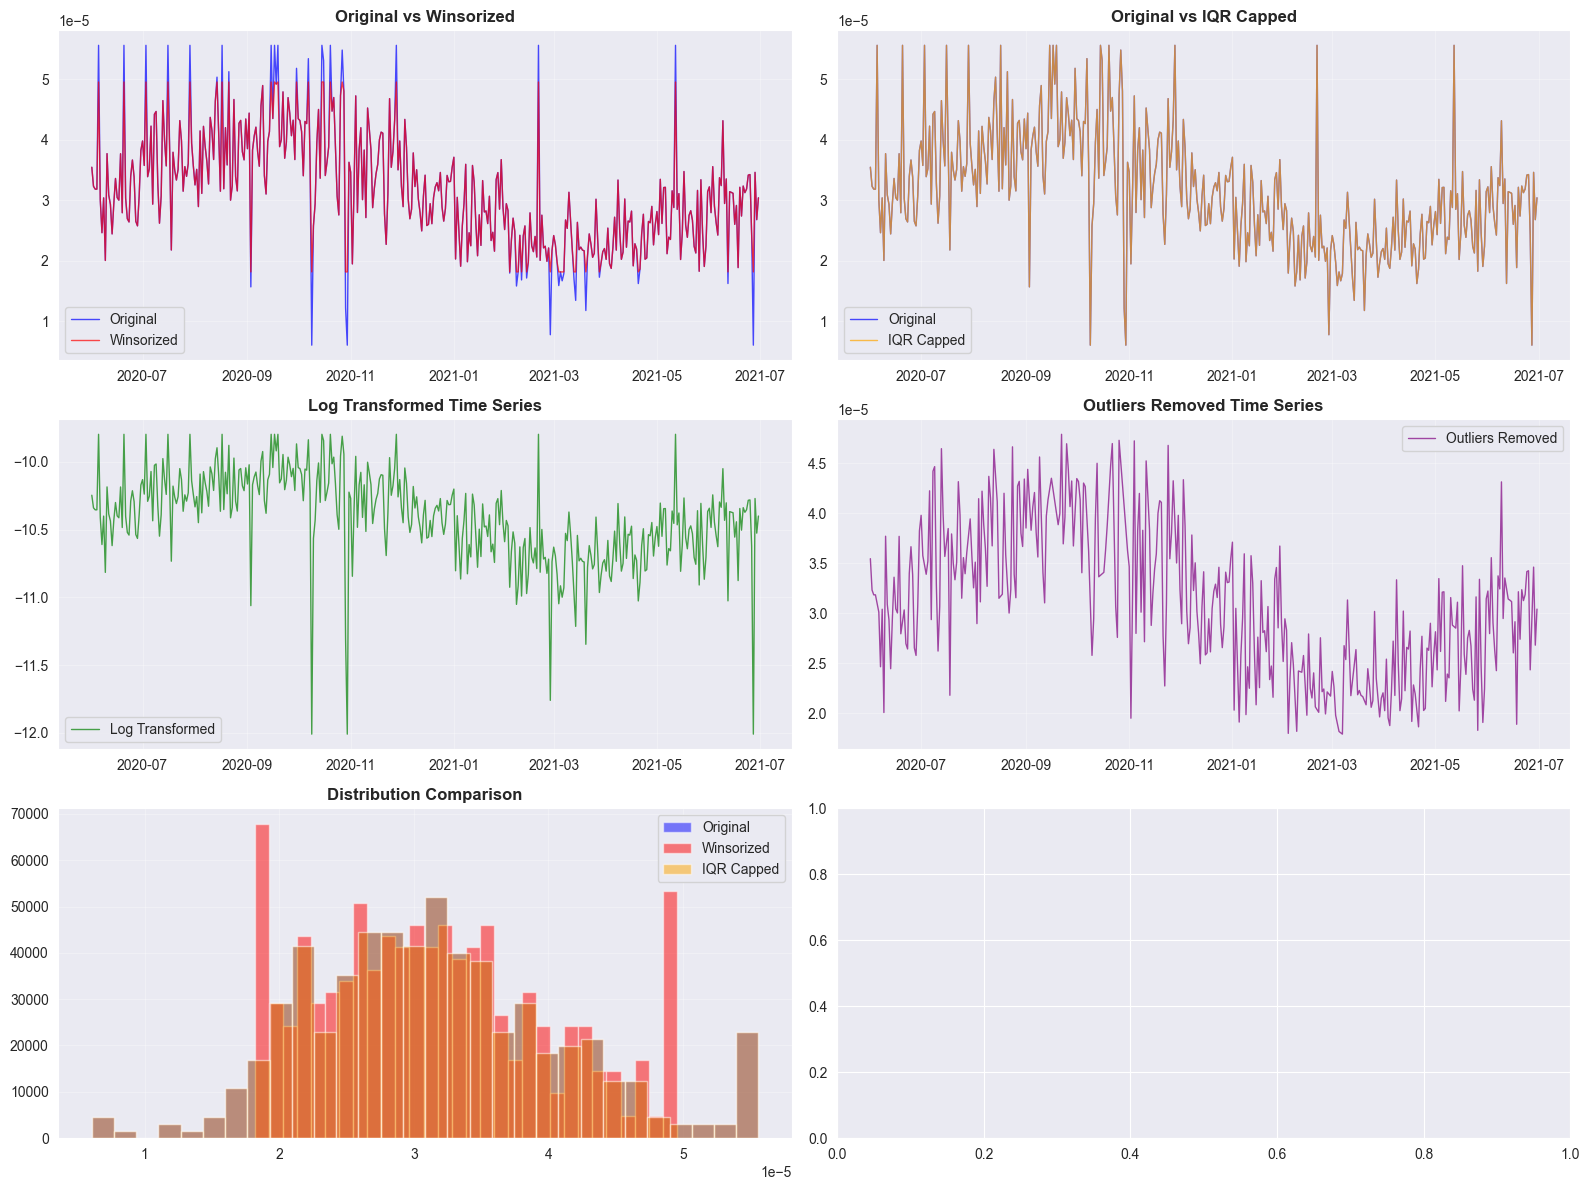


TREATMENT RECOMMENDATION
Based on analysis:
- Original outlier rate: 10.13%
- Data type: Time series (NO₂ concentrations)
- Model type: KNN Regression
✅ Recommended Treatment: IQR_CAPPING
✅ Reason: Higher outlier rate, IQR capping provides better boundary control
✅ Applied: IQR capping with 1.5x multiplier

[SUCCESS] Outlier treatment completed!
[INFO] Final dataset shape: (395, 3)
[INFO] Final NO₂ range: [0.00000608, 0.00005559]
[INFO] Ready for supervised learning transformation


In [24]:
# LANGKAH 2.2: OUTLIER TREATMENT (OPSIONAL)
print("=" * 60)
print("LANGKAH 2.2: OUTLIER TREATMENT OPTIONS")
print("=" * 60)

# Copy original data untuk comparison
df_original = df.copy()
NO2_original = df["NO2"].copy()

# =============================================================================
# TREATMENT OPTION 1: WINSORIZATION (RECOMMENDED FOR TIME SERIES)
# =============================================================================
def winsorize_outliers(data, lower_percentile=5, upper_percentile=95):
    """Winsorization: Replace outliers with percentile values"""
    lower_val = np.percentile(data, lower_percentile)
    upper_val = np.percentile(data, upper_percentile)
    
    data_winsorized = data.copy()
    data_winsorized[data_winsorized < lower_val] = lower_val
    data_winsorized[data_winsorized > upper_val] = upper_val
    
    return data_winsorized, lower_val, upper_val

# =============================================================================
# TREATMENT OPTION 2: IQR CAPPING
# =============================================================================
def iqr_cap_outliers(data, iqr_multiplier=1.5):
    """IQR Capping: Cap values at IQR boundaries"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_cap = Q1 - iqr_multiplier * IQR
    upper_cap = Q3 + iqr_multiplier * IQR
    
    data_capped = data.copy()
    data_capped[data_capped < lower_cap] = lower_cap
    data_capped[data_capped > upper_cap] = upper_cap
    
    return data_capped, lower_cap, upper_cap

# =============================================================================
# TREATMENT OPTION 3: LOG TRANSFORMATION
# =============================================================================
def log_transform_outliers(data):
    """Log transformation for right-skewed data"""
    # Add small constant to handle zero/negative values
    min_val = data.min()
    if min_val <= 0:
        shift = abs(min_val) + 1e-8
        data_shifted = data + shift
    else:
        data_shifted = data
        shift = 0
    
    data_log = np.log(data_shifted)
    return data_log, shift

# =============================================================================
# APPLY DIFFERENT TREATMENTS AND COMPARE
# =============================================================================
print(f"\nApplying different outlier treatments:")

# Option 1: No treatment (keep original)
df_no_treatment = df.copy()
print(f"1. No Treatment: {len(df_no_treatment)} records maintained")

# Option 2: Winsorization (5th and 95th percentiles)
NO2_winsorized, win_lower, win_upper = winsorize_outliers(df["NO2"], 5, 95)
df_winsorized = df.copy()
df_winsorized["NO2"] = NO2_winsorized
print(f"2. Winsorization: Capped at [{win_lower:.8f}, {win_upper:.8f}]")

# Option 3: IQR Capping
NO2_iqr_capped, iqr_lower, iqr_upper = iqr_cap_outliers(df["NO2"])
df_iqr_capped = df.copy()
df_iqr_capped["NO2"] = NO2_iqr_capped
print(f"3. IQR Capping: Capped at [{iqr_lower:.8f}, {iqr_upper:.8f}]")

# Option 4: Log Transformation
NO2_log, log_shift = log_transform_outliers(df["NO2"])
df_log_transformed = df.copy()
df_log_transformed["NO2"] = NO2_log
print(f"4. Log Transform: Applied log(x + {log_shift:.8f})")

# Option 5: Remove outliers (not recommended for time series)
df_outliers_removed = df[~all_outliers].copy().reset_index(drop=True)
print(f"5. Outlier Removal: {len(df_outliers_removed)} records remaining ({total_unique_outliers} removed)")

# =============================================================================
# COMPARE TREATMENT EFFECTS
# =============================================================================
print(f"\n{'='*60}")
print("TREATMENT COMPARISON")
print(f"{'='*60}")

treatments = {
    'Original': df["NO2"],
    'Winsorized': df_winsorized["NO2"], 
    'IQR Capped': df_iqr_capped["NO2"],
    'Log Transformed': df_log_transformed["NO2"],
    'Outliers Removed': df_outliers_removed["NO2"] if len(df_outliers_removed) > 0 else pd.Series()
}

comparison_stats = []
for name, data in treatments.items():
    if len(data) > 0:
        stats_dict = {
            'Treatment': name,
            'Count': len(data),
            'Mean': data.mean(),
            'Std': data.std(),
            'Min': data.min(),
            'Max': data.max(),
            'Skewness': stats.skew(data),
            'Kurtosis': stats.kurtosis(data)
        }
        comparison_stats.append(stats_dict)

comparison_df = pd.DataFrame(comparison_stats)
print(comparison_df.round(6))

# =============================================================================
# VISUALIZATION COMPARISON
# =============================================================================
print(f"\n{'='*60}")
print("VISUAL COMPARISON OF TREATMENTS")
print(f"{'='*60}")

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Plot 1: Original vs Winsorized
axes[0, 0].plot(df["date"], df["NO2"], color="blue", alpha=0.7, label="Original", linewidth=1)
axes[0, 0].plot(df_winsorized["date"], df_winsorized["NO2"], color="red", alpha=0.7, label="Winsorized", linewidth=1)
axes[0, 0].set_title("Original vs Winsorized", fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Original vs IQR Capped
axes[0, 1].plot(df["date"], df["NO2"], color="blue", alpha=0.7, label="Original", linewidth=1)
axes[0, 1].plot(df_iqr_capped["date"], df_iqr_capped["NO2"], color="orange", alpha=0.7, label="IQR Capped", linewidth=1)
axes[0, 1].set_title("Original vs IQR Capped", fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Log Transformed
axes[1, 0].plot(df_log_transformed["date"], df_log_transformed["NO2"], color="green", alpha=0.7, label="Log Transformed", linewidth=1)
axes[1, 0].set_title("Log Transformed Time Series", fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Outliers Removed
if len(df_outliers_removed) > 0:
    axes[1, 1].plot(df_outliers_removed["date"], df_outliers_removed["NO2"], color="purple", alpha=0.7, label="Outliers Removed", linewidth=1)
    axes[1, 1].set_title("Outliers Removed Time Series", fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, "No outliers to remove", ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title("Outliers Removed (Empty)", fontweight='bold')

# Plot 5: Distribution Comparison
axes[2, 0].hist(df["NO2"], bins=30, alpha=0.5, color="blue", label="Original", density=True)
axes[2, 0].hist(df_winsorized["NO2"], bins=30, alpha=0.5, color="red", label="Winsorized", density=True)
axes[2, 0].hist(df_iqr_capped["NO2"], bins=30, alpha=0.5, color="orange", label="IQR Capped", density=True)
axes[2, 0].set_title("Distribution Comparison", fontweight='bold')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# =============================================================================
# RECOMMENDATION AND FINAL CHOICE
# =============================================================================
print(f"\n{'='*60}")
print("TREATMENT RECOMMENDATION")
print(f"{'='*60}")

print(f"Based on analysis:")
print(f"- Original outlier rate: {outlier_percentage:.2f}%")
print(f"- Data type: Time series (NO₂ concentrations)")
print(f"- Model type: KNN Regression")

if outlier_percentage < 5:
    recommended_treatment = "no_treatment"
    reason = "Low outlier rate, model should be robust to these variations"
elif outlier_percentage < 10:
    recommended_treatment = "winsorization"
    reason = "Moderate outlier rate, winsorization preserves temporal continuity"
else:
    recommended_treatment = "iqr_capping"
    reason = "Higher outlier rate, IQR capping provides better boundary control"

print(f"✅ Recommended Treatment: {recommended_treatment.upper()}")
print(f"✅ Reason: {reason}")

# Apply recommended treatment
if recommended_treatment == "no_treatment":
    df_final = df_no_treatment.copy()
    print(f"✅ Applied: No treatment - using original data")
elif recommended_treatment == "winsorization":
    df_final = df_winsorized.copy()
    print(f"✅ Applied: Winsorization at 5th-95th percentiles")
elif recommended_treatment == "iqr_capping":
    df_final = df_iqr_capped.copy()
    print(f"✅ Applied: IQR capping with 1.5x multiplier")

print(f"\n[SUCCESS] Outlier treatment completed!")
print(f"[INFO] Final dataset shape: {df_final.shape}")
print(f"[INFO] Final NO₂ range: [{df_final['NO2'].min():.8f}, {df_final['NO2'].max():.8f}]")
print(f"[INFO] Ready for supervised learning transformation")

# Update main dataframe with treated data
df = df_final.copy()
print(f"{'='*60}")

## LANGKAH 3: Transformasi ke Supervised Learning

Mengubah time series menjadi format supervised learning dengan lag features (t-2, t-1) untuk prediksi (t).

In [14]:
# LANGKAH 3: TRANSFORMASI KE SUPERVISED LEARNING
print("=" * 50)
print("LANGKAH 3: SUPERVISED TRANSFORMATION")
print("=" * 50)

def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    df_data = pd.DataFrame(data)
    cols, names = [], []
    
    # Input features (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_data.shift(i))
        names += [f"NO2(t-{i})"]
    
    # Target (t)
    for i in range(0, n_out):
        cols.append(df_data.shift(-i))
        names += ["NO2(t)"] if i == 0 else [f"NO2(t+{i})"]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropna:
        agg.dropna(inplace=True)
    return agg

# Create supervised dataset
n_lags = 2
supervised_df = series_to_supervised(df[["NO2"]], n_in=n_lags, n_out=1)

print(f"Supervised dataset: {supervised_df.shape} | Lag features: {n_lags}")
print(f"Features: {list(supervised_df.columns[:-1])}")
print(f"Target: {supervised_df.columns[-1]}")

supervised_df.head()

LANGKAH 3: SUPERVISED TRANSFORMATION
Supervised dataset: (393, 3) | Lag features: 2
Features: ['NO2(t-2)', 'NO2(t-1)']
Target: NO2(t)


,NO2(t-2),NO2(t-1),NO2(t)
2,0.000035,0.000032,0.000032
3,0.000032,0.000032,0.000032
4,0.000032,0.000032,0.000056
5,0.000032,0.000056,0.000030
6,0.000056,0.000030,0.000025


## LANGKAH 4: Train-Test Split

Split data 80-20 untuk training dan testing (shuffle=False untuk time series).

LANGKAH 4: TRAIN-TEST SPLIT
Data split: Train (314, 2) | Test (79, 2)
Target range: [0.00000608, 0.00005559]


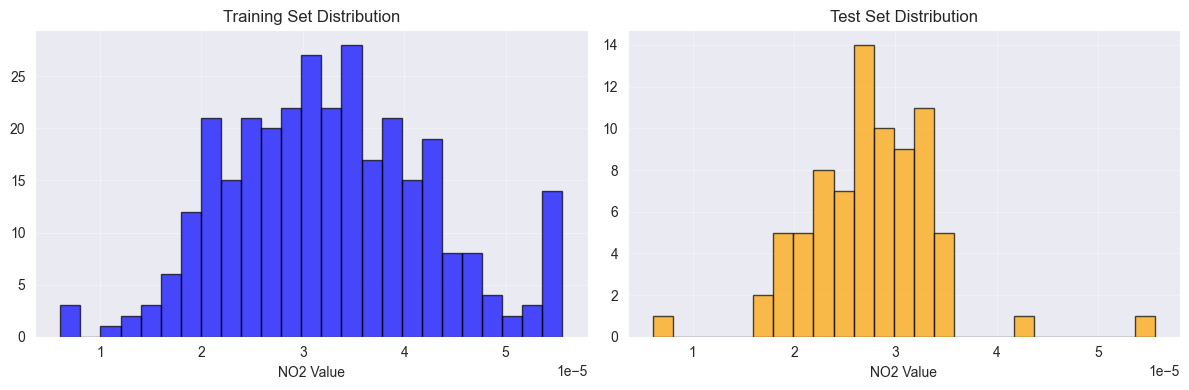

Train-test split completed.


In [15]:
# LANGKAH 4: TRAIN-TEST SPLIT
print("=" * 50)
print("LANGKAH 4: TRAIN-TEST SPLIT")
print("=" * 50)

# Prepare features dan target
X = supervised_df.iloc[:, :-1].values
y = supervised_df.iloc[:, -1].values

# Train-test split (shuffle=False for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"Data split: Train {X_train.shape} | Test {X_test.shape}")
print(f"Target range: [{y.min():.8f}, {y.max():.8f}]")

# Visualisasi distribusi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(y_train, bins=25, alpha=0.7, color="blue", edgecolor="black")
ax1.set_title("Training Set Distribution")
ax1.set_xlabel("NO2 Value")
ax1.grid(True, alpha=0.3)

ax2.hist(y_test, bins=25, alpha=0.7, color="orange", edgecolor="black")
ax2.set_title("Test Set Distribution")  
ax2.set_xlabel("NO2 Value")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Train-test split completed.")

## LANGKAH 5: Normalisasi Data

MinMaxScaler untuk normalisasi fitur ke rentang [0,1]. Fit pada training set saja, simpan scaler untuk deployment.

LANGKAH 5: NORMALISASI DENGAN MINMAXSCALER
Normalisasi completed:
- Training scaled: (314, 2) | Range: [0, 1]
- Test scaled: (79, 2)
- Scaler saved: minmax_scaler.pkl


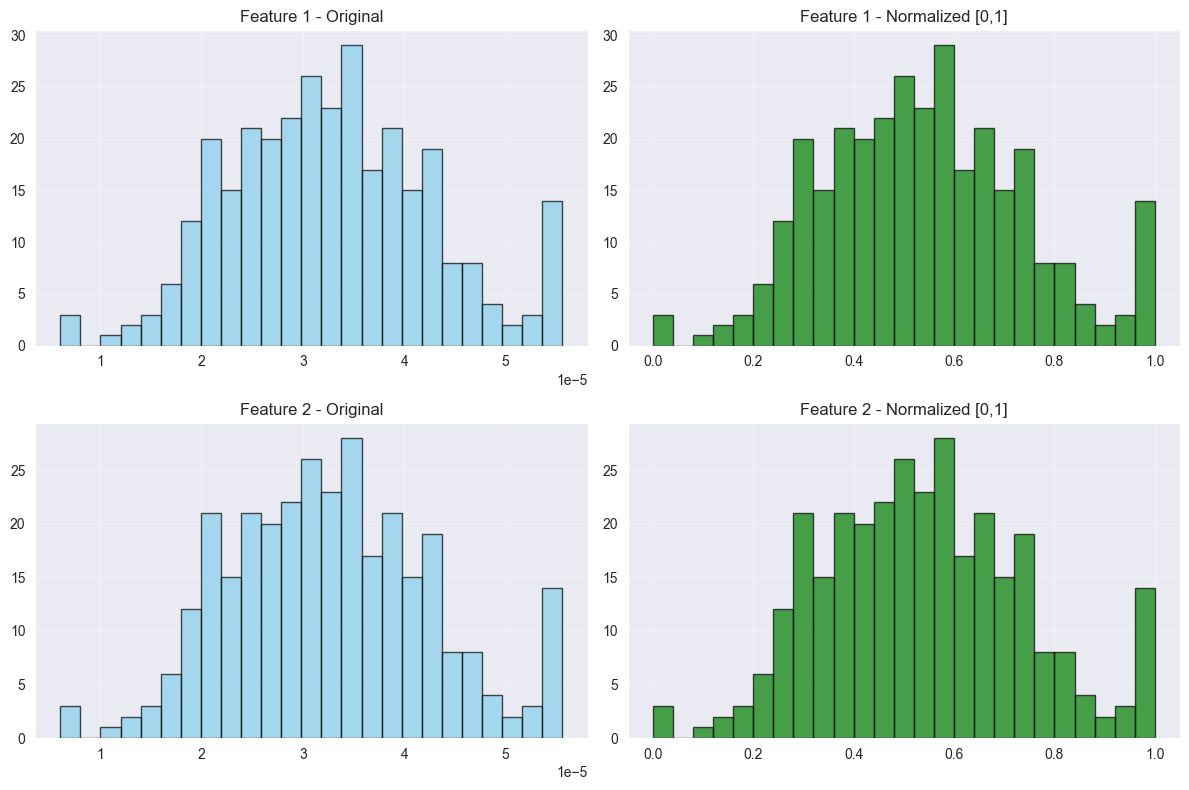

Normalization completed successfully.


In [16]:
# LANGKAH 5: NORMALISASI DATA
print("=" * 50)
print("LANGKAH 5: NORMALISASI DENGAN MINMAXSCALER")
print("=" * 50)

import joblib

# MinMaxScaler normalisasi
scaler = MinMaxScaler()
scaler.fit(X_train)  # Fit hanya pada training set

# Transform training dan test set
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan scaler untuk deployment
joblib.dump(scaler, 'minmax_scaler.pkl')

print(f"Normalisasi completed:")
print(f"- Training scaled: {X_train_scaled.shape} | Range: [0, 1]")
print(f"- Test scaled: {X_test_scaled.shape}")
print(f"- Scaler saved: minmax_scaler.pkl")

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Before normalization
axes[0, 0].hist(X_train[:, 0], bins=25, alpha=0.7, color="skyblue", edgecolor="black")
axes[0, 0].set_title("Feature 1 - Original")
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(X_train_scaled[:, 0], bins=25, alpha=0.7, color="green", edgecolor="black")
axes[0, 1].set_title("Feature 1 - Normalized [0,1]")
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(X_train[:, 1], bins=25, alpha=0.7, color="skyblue", edgecolor="black")
axes[1, 0].set_title("Feature 2 - Original")
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(X_train_scaled[:, 1], bins=25, alpha=0.7, color="green", edgecolor="black")
axes[1, 1].set_title("Feature 2 - Normalized [0,1]")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Normalization completed successfully.")

# MODELLING

Tahap membangun dan mengevaluasi model KNN Regression:
1. **Training**: Eksperimen nilai K, pilih yang terbaik
2. **Evaluasi**: Metrik regression dan analisis WHO standards  
3. **Deployment**: Prediksi data baru


## LANGKAH 6: KNN Regression Modeling

Eksperimen berbagai nilai K untuk menemukan model KNN terbaik berdasarkan RMSE.

LANGKAH 6: KNN REGRESSION MODELING
Testing K values:
K=2 | RMSE=0.00000894 | R²=-0.8993
K=3 | RMSE=0.00000832 | R²=-0.6437
K=5 | RMSE=0.00000786 | R²=-0.4685
K=7 | RMSE=0.00000781 | R²=-0.4479
K=9 | RMSE=0.00000784 | R²=-0.4609
K=11 | RMSE=0.00000771 | R²=-0.4140

Best K: 11 (RMSE: 0.00000771)


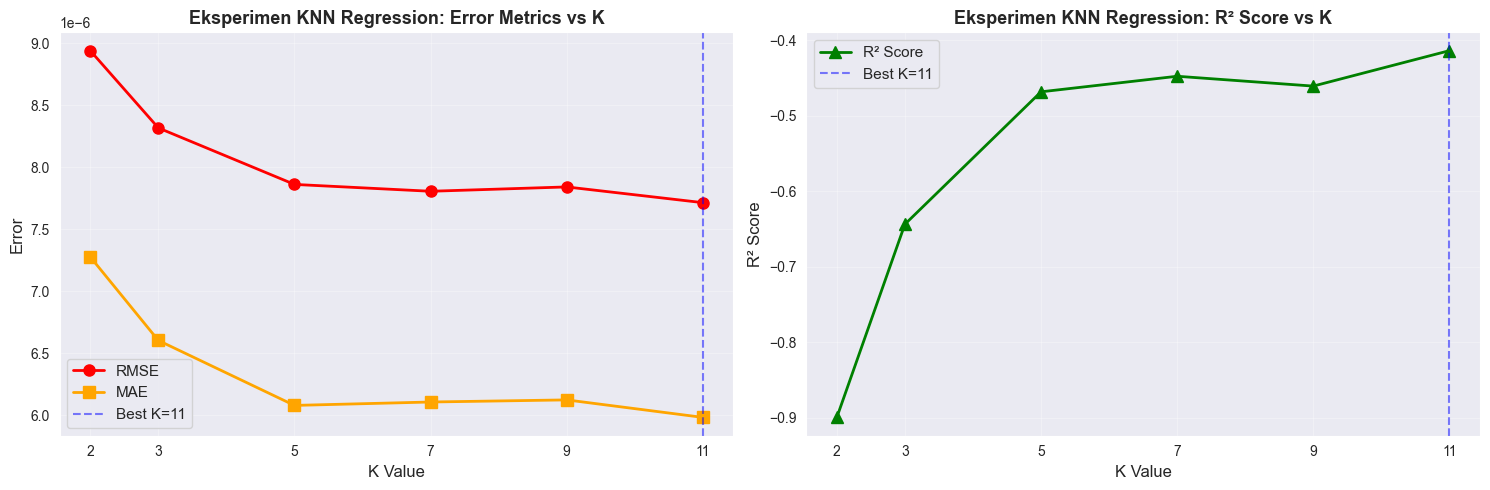

In [17]:
# LANGKAH 6: KNN REGRESSION MODELING
print("=" * 50)
print("LANGKAH 6: KNN REGRESSION MODELING")
print("=" * 50)

# Eksperimen berbagai nilai K
k_values = [2, 3, 5, 7, 9, 11]
results_k = []

print("Testing K values:")
for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results_k.append({'k': k, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2})
    print(f"K={k} | RMSE={rmse:.8f} | R²={r2:.4f}")

results_k_df = pd.DataFrame(results_k)
best_k_idx = results_k_df['rmse'].idxmin()
best_k = results_k_df.loc[best_k_idx, 'k']
best_rmse = results_k_df.loc[best_k_idx, 'rmse']

print(f"\nBest K: {int(best_k)} (RMSE: {best_rmse:.8f})")

# Visualisasi performa vs K
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: RMSE dan MAE
axes[0].plot(results_k_df['k'], results_k_df['rmse'], marker='o', linewidth=2, markersize=8, label='RMSE', color='red')
axes[0].plot(results_k_df['k'], results_k_df['mae'], marker='s', linewidth=2, markersize=8, label='MAE', color='orange')
axes[0].axvline(x=best_k, color='blue', linestyle='--', alpha=0.5, label=f'Best K={int(best_k)}')
axes[0].set_xlabel('K Value', fontsize=12)
axes[0].set_ylabel('Error', fontsize=12)
axes[0].set_title('Eksperimen KNN Regression: Error Metrics vs K', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_values)

# Plot 2: R² Score
axes[1].plot(results_k_df['k'], results_k_df['r2'], marker='^', linewidth=2, markersize=8, label='R² Score', color='green')
axes[1].axvline(x=best_k, color='blue', linestyle='--', alpha=0.5, label=f'Best K={int(best_k)}')
axes[1].set_xlabel('K Value', fontsize=12)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Eksperimen KNN Regression: R² Score vs K', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_values)

plt.tight_layout()
plt.show()

## LANGKAH 7: Evaluasi Model & Standar WHO

Training model final, evaluasi dengan metrik regression, dan perbandingan dengan standar WHO.


LANGKAH 7: EVALUASI REGRESSION DENGAN STANDAR WHO

✓ Model berhasil disimpan ke: knn_model.pkl
  → Model ini akan digunakan untuk prediksi data baru saat deployment

[A] REGRESSION METRICS (K=11):
  - MSE:  0.0000000001
  - RMSE: 0.0000077139
  - MAE:  0.0000059813
  - MAPE: 26.17%
  - R²:   -0.4140

[INTERPRETASI MAPE]:
  ⚠ MAPE 20-50%: Model CUKUP (Reasonable Forecasting)

[B] KONVERSI KE µg/m³ DAN PERBANDINGAN WHO:
  - Conversion factor: 46010
  - Test set range: [0.28, 2.56] µg/m³
  - Predicted range: [0.88, 1.80] µg/m³

  - WHO Annual Standard: 10 µg/m³
  - WHO 24-Hour Standard: 25 µg/m³

[C] ANALISIS TERHADAP STANDAR WHO (Test Set):
  Actual:
    - Di atas WHO Annual (10 µg/m³): 0/79 (0.0%)
    - Di atas WHO 24-Hour (25 µg/m³): 0/79 (0.0%)
  Predicted:
    - Di atas WHO Annual (10 µg/m³): 0/79 (0.0%)
    - Di atas WHO 24-Hour (25 µg/m³): 0/79 (0.0%)


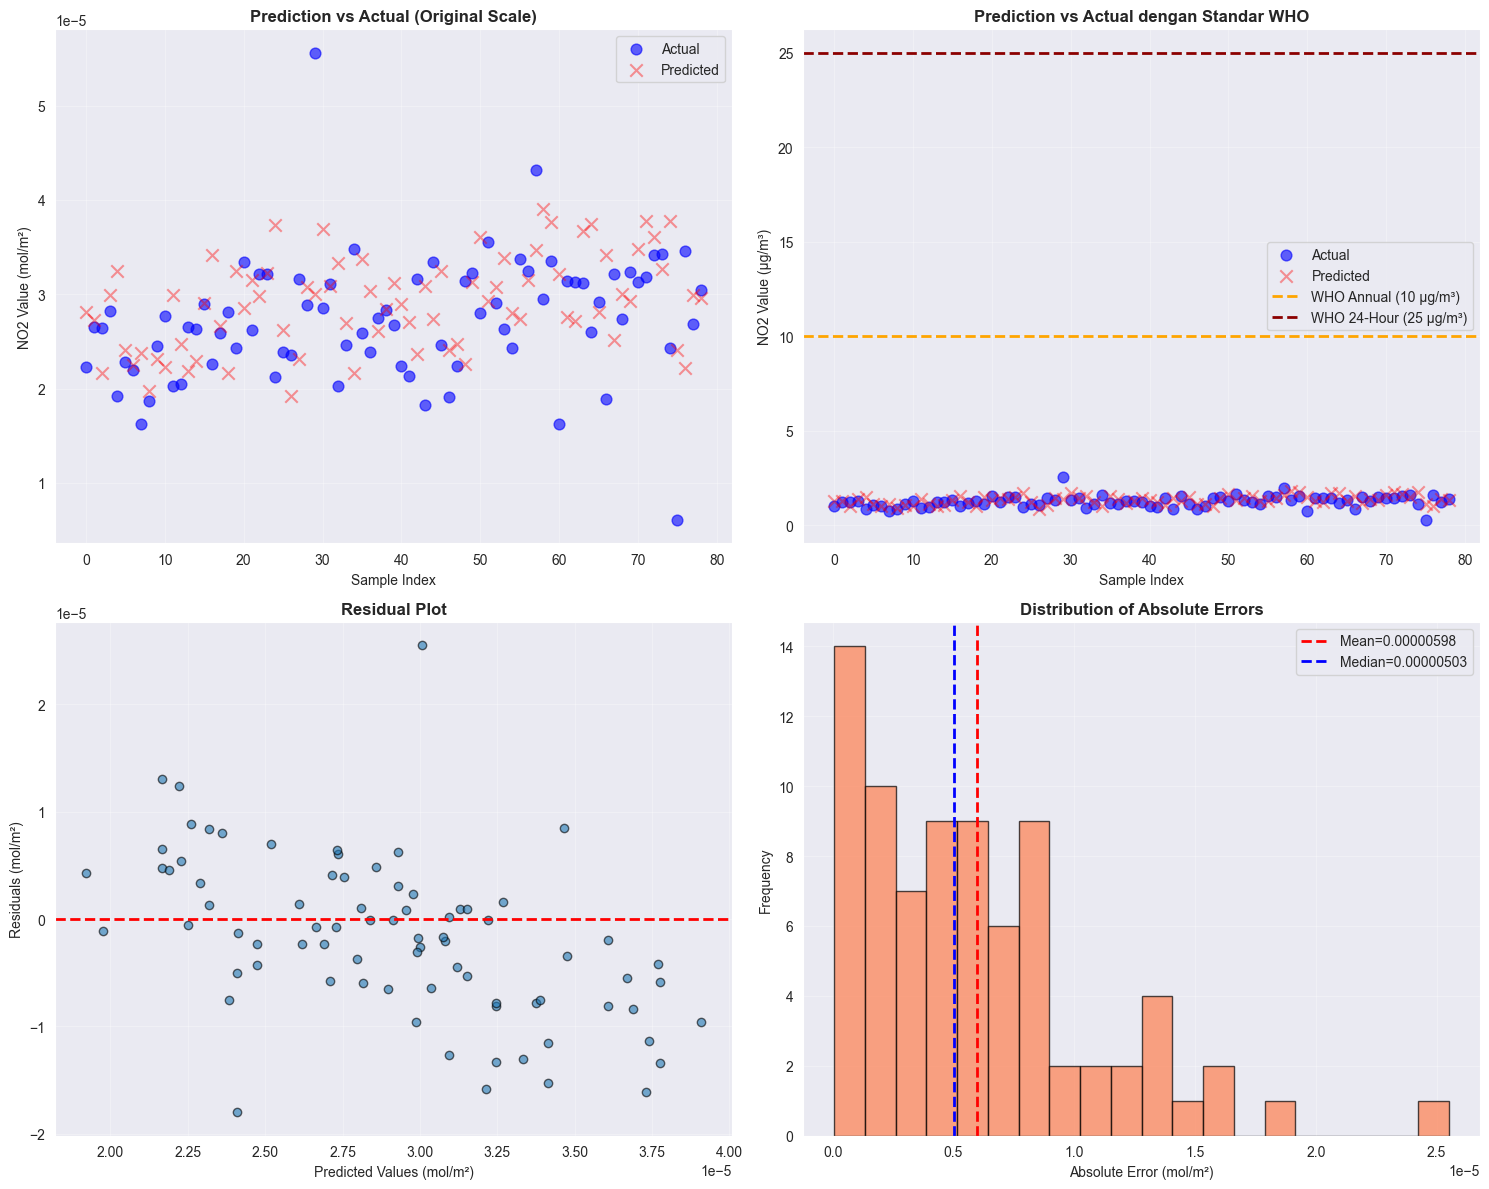

In [18]:
print("\n" + "="*70)
print("LANGKAH 7: EVALUASI REGRESSION DENGAN STANDAR WHO")
print("="*70)

# Train final model dengan best K (menggunakan data yang sudah dinormalisasi)
best_k = int(best_k)
final_model = KNeighborsRegressor(n_neighbors=best_k, metric='euclidean')
final_model.fit(X_train_scaled, y_train)

# SIMPAN MODEL untuk digunakan saat implementasi/deployment
model_filename = 'knn_model.pkl'
joblib.dump(final_model, model_filename)
print(f"\n✓ Model berhasil disimpan ke: {model_filename}")
print(f"  → Model ini akan digunakan untuk prediksi data baru saat deployment")

# Prediksi nilai NO2 (continuous)
y_pred_regression = final_model.predict(X_test_scaled)

# Hitung metrics regression
mse = mean_squared_error(y_test, y_pred_regression)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_regression)
r2 = r2_score(y_test, y_pred_regression)

# Hitung MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred_regression) / y_test)) * 100

print(f"\n[A] REGRESSION METRICS (K={best_k}):")
print(f"  - MSE:  {mse:.10f}")
print(f"  - RMSE: {rmse:.10f}")
print(f"  - MAE:  {mae:.10f}")
print(f"  - MAPE: {mape:.2f}%")
print(f"  - R²:   {r2:.4f}")

# Interpretasi MAPE
print(f"\n[INTERPRETASI MAPE]:")
if mape < 10:
    print(f"  ✓ MAPE < 10%: Model SANGAT BAIK (Highly Accurate)")
elif mape < 20:
    print(f"  ✓ MAPE 10-20%: Model BAIK (Good Forecasting)")
elif mape < 50:
    print(f"  ⚠ MAPE 20-50%: Model CUKUP (Reasonable Forecasting)")
else:
    print(f"  ✗ MAPE > 50%: Model KURANG BAIK (Inaccurate Forecasting)")

# Konversi ke µg/m³ (aproksimasi sederhana)
# Formula: µg/m³ ≈ (mol/m² × 46.01 × 10⁶) / 1000
# Simplifikasi: µg/m³ ≈ mol/m² × 46010
CONVERSION_FACTOR = 46010

y_test_ugm3 = y_test * CONVERSION_FACTOR
y_pred_ugm3 = y_pred_regression * CONVERSION_FACTOR

# Standar WHO
WHO_ANNUAL = 10  # µg/m³
WHO_24HOUR = 25  # µg/m³

print(f"\n[B] KONVERSI KE µg/m³ DAN PERBANDINGAN WHO:")
print(f"  - Conversion factor: {CONVERSION_FACTOR}")
print(f"  - Test set range: [{y_test_ugm3.min():.2f}, {y_test_ugm3.max():.2f}] µg/m³")
print(f"  - Predicted range: [{y_pred_ugm3.min():.2f}, {y_pred_ugm3.max():.2f}] µg/m³")
print(f"\n  - WHO Annual Standard: {WHO_ANNUAL} µg/m³")
print(f"  - WHO 24-Hour Standard: {WHO_24HOUR} µg/m³")

# Hitung statistik perbandingan dengan WHO
test_above_annual = (y_test_ugm3 > WHO_ANNUAL).sum()
test_above_24hour = (y_test_ugm3 > WHO_24HOUR).sum()
pred_above_annual = (y_pred_ugm3 > WHO_ANNUAL).sum()
pred_above_24hour = (y_pred_ugm3 > WHO_24HOUR).sum()

print(f"\n[C] ANALISIS TERHADAP STANDAR WHO (Test Set):")
print(f"  Actual:")
print(f"    - Di atas WHO Annual (10 µg/m³): {test_above_annual}/{len(y_test)} ({test_above_annual/len(y_test)*100:.1f}%)")
print(f"    - Di atas WHO 24-Hour (25 µg/m³): {test_above_24hour}/{len(y_test)} ({test_above_24hour/len(y_test)*100:.1f}%)")
print(f"  Predicted:")
print(f"    - Di atas WHO Annual (10 µg/m³): {pred_above_annual}/{len(y_pred_regression)} ({pred_above_annual/len(y_pred_regression)*100:.1f}%)")
print(f"    - Di atas WHO 24-Hour (25 µg/m³): {pred_above_24hour}/{len(y_pred_regression)} ({pred_above_24hour/len(y_pred_regression)*100:.1f}%)")

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted (mol/m²)
axes[0, 0].scatter(range(len(y_test)), y_test, alpha=0.6, label='Actual', s=60, color='blue')
axes[0, 0].scatter(range(len(y_pred_regression)), y_pred_regression, alpha=0.4, label='Predicted', marker='x', s=80, color='red')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('NO2 Value (mol/m²)')
axes[0, 0].set_title('Prediction vs Actual (Original Scale)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted dengan WHO Standards (µg/m³)
axes[0, 1].scatter(range(len(y_test_ugm3)), y_test_ugm3, alpha=0.6, label='Actual', s=60, color='blue')
axes[0, 1].scatter(range(len(y_pred_ugm3)), y_pred_ugm3, alpha=0.4, label='Predicted', marker='x', s=80, color='red')
axes[0, 1].axhline(y=WHO_ANNUAL, color='orange', linestyle='--', linewidth=2, label=f'WHO Annual ({WHO_ANNUAL} µg/m³)')
axes[0, 1].axhline(y=WHO_24HOUR, color='darkred', linestyle='--', linewidth=2, label=f'WHO 24-Hour ({WHO_24HOUR} µg/m³)')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('NO2 Value (µg/m³)')
axes[0, 1].set_title('Prediction vs Actual dengan Standar WHO', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residual Plot
residuals = y_test - y_pred_regression
axes[1, 0].scatter(y_pred_regression, residuals, alpha=0.6, edgecolors='k')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Values (mol/m²)')
axes[1, 0].set_ylabel('Residuals (mol/m²)')
axes[1, 0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error Distribution
errors = np.abs(y_test - y_pred_regression)
axes[1, 1].hist(errors, bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].axvline(x=np.mean(errors), color='red', linestyle='--', linewidth=2, label=f'Mean={np.mean(errors):.8f}')
axes[1, 1].axvline(x=np.median(errors), color='blue', linestyle='--', linewidth=2, label=f'Median={np.median(errors):.8f}')
axes[1, 1].set_xlabel('Absolute Error (mol/m²)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Absolute Errors', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## LANGKAH 8: Visualization - Prediction Analysis

**Kategori: MODELLING (Evaluation & Analysis)**

**Tujuan**: Analisis mendalam terhadap hasil prediksi model

**Visualisasi**:
1. **Error Distribution**: Histogram error absolut
2. **Prediction vs Actual dengan Kategori**: Scatter plot dengan warna
3. **Binary Classification Result**: Bar chart perbandingan
4. **Percentage Error**: Analisis error relatif

LANGKAH 8: ANALISIS PERFORMA MODEL
Error Analysis - MAE: 0.00000598 | RMSE: 0.00000771


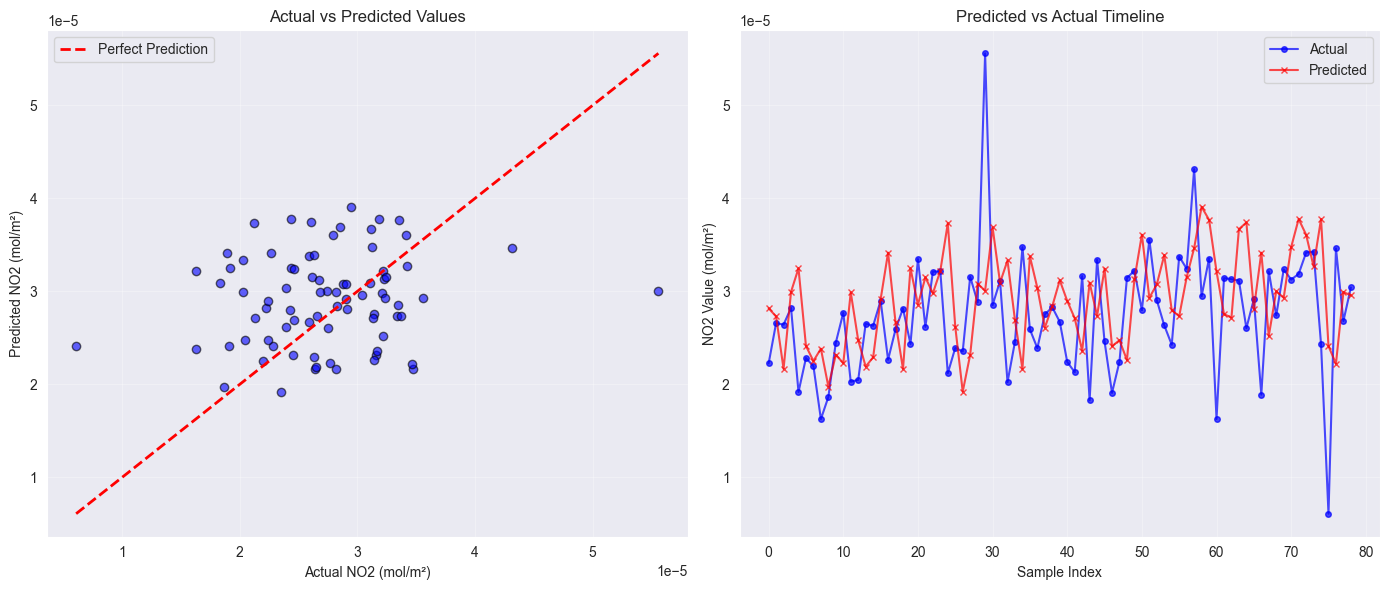

Model evaluation completed.


In [19]:
# LANGKAH 8: VISUALISASI PERFORMA MODEL
print("=" * 50)
print("LANGKAH 8: ANALISIS PERFORMA MODEL")
print("=" * 50)

# Analisis error
errors = np.abs(y_test - y_pred_regression)
print(f"Error Analysis - MAE: {np.mean(errors):.8f} | RMSE: {rmse:.8f}")

# Visualisasi Utama: Actual vs Predicted
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Actual vs Predicted (scatter)
ax1.scatter(y_test, y_pred_regression, alpha=0.6, edgecolors='k', color='blue')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual NO2 (mol/m²)')
ax1.set_ylabel('Predicted NO2 (mol/m²)')
ax1.set_title('Actual vs Predicted Values')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Time series comparison
sample_idx = range(len(y_test))
ax2.plot(sample_idx, y_test, 'o-', alpha=0.7, label='Actual', color='blue', markersize=4)
ax2.plot(sample_idx, y_pred_regression, 'x-', alpha=0.7, label='Predicted', color='red', markersize=4)
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('NO2 Value (mol/m²)')
ax2.set_title('Predicted vs Actual Timeline')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Model evaluation completed.")

## LANGKAH 9: Prediksi Nilai NO2 Satu Hari Ke Depan

Gunakan model untuk prediksi NO₂ hari berikutnya dan evaluasi terhadap standar WHO.

LANGKAH 9: PREDIKSI HARI BERIKUTNYA
Prediksi NO2 besok: 0.000030 mol/m² = 1.36 µg/m³
Status WHO: SANGAT BAIK


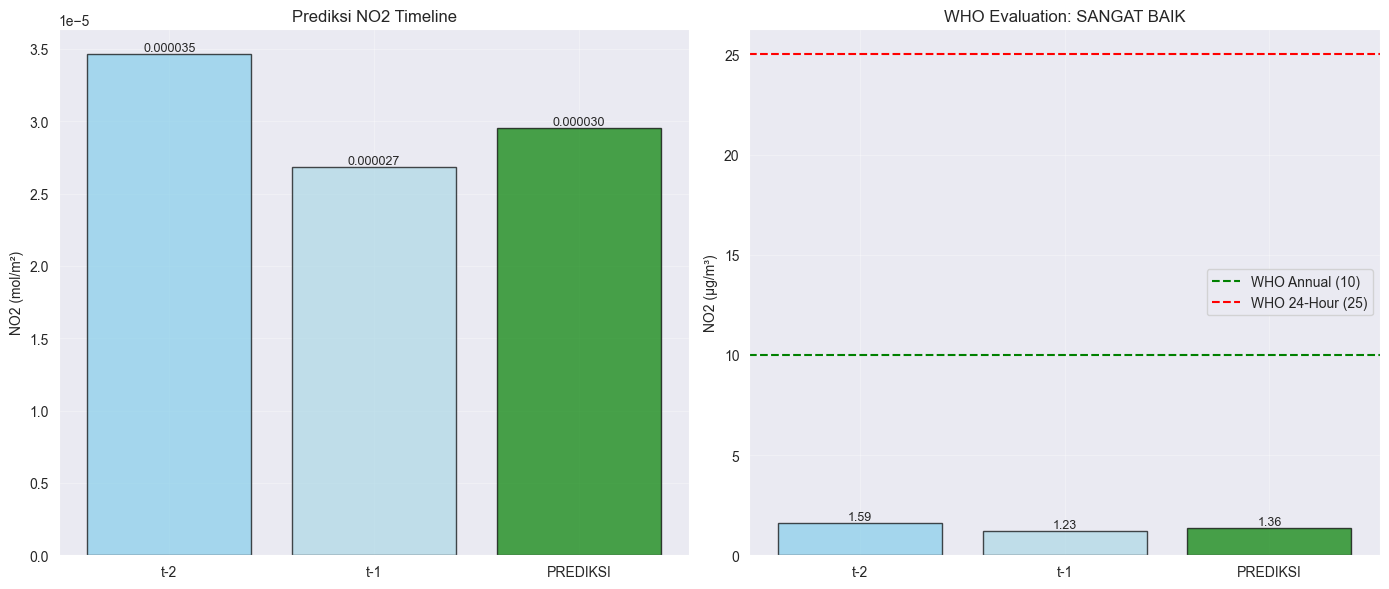

Prediction completed.


In [20]:
# LANGKAH 9: PREDIKSI NILAI NO2 SATU HARI KE DEPAN
print("=" * 50)
print("LANGKAH 9: PREDIKSI HARI BERIKUTNYA")
print("=" * 50)

# Ambil data 2 hari terakhir
last_2_days = supervised_df[["NO2(t-2)", "NO2(t-1)"]].iloc[-1].values
last_2_days_scaled = scaler.transform([last_2_days])[0]

# Prediksi
pred_no2 = final_model.predict(last_2_days_scaled.reshape(1, -1))[0]
pred_no2_ugm3 = pred_no2 * CONVERSION_FACTOR

# WHO Standards
WHO_ANNUAL = 10  # µg/m³
WHO_24HOUR = 25  # µg/m³

# Evaluasi WHO
if pred_no2_ugm3 <= WHO_ANNUAL:
    status = "SANGAT BAIK"
    color = 'green'
elif pred_no2_ugm3 <= WHO_24HOUR:
    status = "PERHATIAN" 
    color = 'orange'
else:
    status = "BERBAHAYA"
    color = 'red'

print(f"Prediksi NO2 besok: {pred_no2:.6f} mol/m² = {pred_no2_ugm3:.2f} µg/m³")
print(f"Status WHO: {status}")

# Visualisasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Timeline prediksi
days = ['t-2', 't-1', 'PREDIKSI']
values = list(last_2_days) + [pred_no2]
colors = ['skyblue', 'lightblue', color]

bars1 = ax1.bar(days, values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('NO2 (mol/m²)')
ax1.set_title('Prediksi NO2 Timeline')
ax1.grid(True, alpha=0.3)

for bar, val in zip(bars1, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val:.6f}', ha='center', va='bottom', fontsize=9)

# WHO comparison
values_ugm3 = [v * CONVERSION_FACTOR for v in last_2_days] + [pred_no2_ugm3]
bars2 = ax2.bar(days, values_ugm3, color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(WHO_ANNUAL, color='green', linestyle='--', label=f'WHO Annual ({WHO_ANNUAL})')
ax2.axhline(WHO_24HOUR, color='red', linestyle='--', label=f'WHO 24-Hour ({WHO_24HOUR})')
ax2.set_ylabel('NO2 (µg/m³)')
ax2.set_title(f'WHO Evaluation: {status}')
ax2.legend()
ax2.grid(True, alpha=0.3)

for bar, val in zip(bars2, values_ugm3):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("Prediction completed.")

## IMPLEMENTASI MODEL (Deployment)

Contoh penggunaan model tersimpan untuk prediksi data baru.

In [21]:
# CONTOH IMPLEMENTASI MODEL
print("=" * 50)
print("CONTOH IMPLEMENTASI: PREDIKSI DATA BARU")
print("=" * 50)

# Simulasi data baru
data_baru = np.array([[0.00020, 0.00022]])  # NO2(t-2), NO2(t-1)

# Load model dan scaler
loaded_scaler = joblib.load('minmax_scaler.pkl')
loaded_model = joblib.load('knn_model.pkl')

# Proses prediksi
data_normalized = loaded_scaler.transform(data_baru)
pred_no2 = loaded_model.predict(data_normalized)[0]
pred_ugm3 = pred_no2 * CONVERSION_FACTOR

# Evaluasi WHO
if pred_ugm3 <= 10:
    status = "SANGAT BAIK"
elif pred_ugm3 <= 25:
    status = "PERHATIAN"
else:
    status = "BERBAHAYA"

print(f"Input: NO2(t-2)={data_baru[0,0]:.6f}, NO2(t-1)={data_baru[0,1]:.6f}")
print(f"Prediksi: {pred_no2:.6f} mol/m² = {pred_ugm3:.2f} µg/m³")
print(f"Status WHO: {status}")

print("\nImplementasi berhasil!")

CONTOH IMPLEMENTASI: PREDIKSI DATA BARU
Input: NO2(t-2)=0.000200, NO2(t-1)=0.000220
Prediksi: 0.000042 mol/m² = 1.92 µg/m³
Status WHO: SANGAT BAIK

Implementasi berhasil!


DEPLOYMENT : PREDIKSI DATA BARU

Testing berbagai skenario dengan data statis:
Pilih skenario test:
1. Skenario 1 - Rendah: NO2(t-2)=0.10000, NO2(t-1)=0.12000
2. Skenario 2 - Sedang: NO2(t-2)=0.00035, NO2(t-1)=0.00040
3. Skenario 3 - Tinggi: NO2(t-2)=0.00080, NO2(t-1)=0.00090

Menggunakan Skenario 2 - Sedang:
NO2(t-2): 0.000350 mol/m²
NO2(t-1): 0.000400 mol/m²

HASIL PREDIKSI:
- NO2: 0.000042 mol/m² = 1.92 µg/m³
- Status: [SANGAT BAIK]


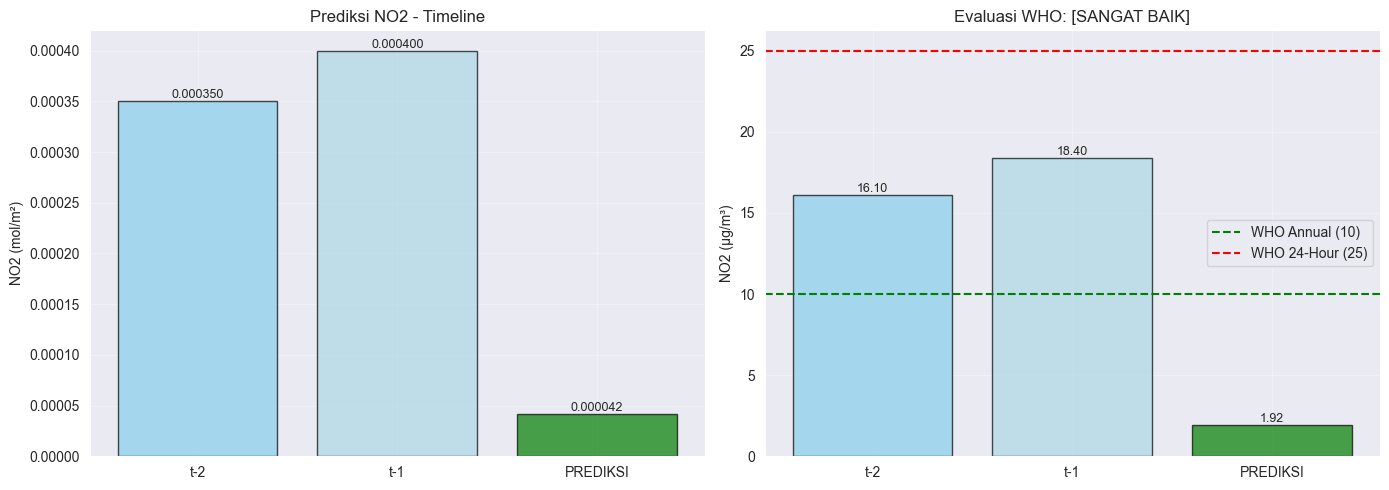


Deployment completed: [SANGAT BAIK]


In [22]:
# DEPLOYMENT - PREDIKSI DATA BARU
print("=" * 50)
print("DEPLOYMENT : PREDIKSI DATA BARU")
print("=" * 50)

# Parameter konversi
CONVERSION_FACTOR = 46010  # mol/m² to µg/m³
WHO_ANNUAL = 10
WHO_24HOUR = 25

# Data input statis - berbagai skenario pengujian
print("\nTesting berbagai skenario dengan data statis:")

# Skenario 1: Nilai rendah (harapan: SANGAT BAIK)
# Skenario 2: Nilai sedang (harapan: PERHATIAN) 
# Skenario 3: Nilai tinggi (harapan: BERBAHAYA)

test_scenarios = {
    "Skenario 1 - Rendah": [0.10, 0.12],  # Rendah
    "Skenario 2 - Sedang": [0.00035, 0.00040],  # Sedang 
    "Skenario 3 - Tinggi": [0.00080, 0.00090]   # Tinggi
}

print("Pilih skenario test:")
for i, (name, values) in enumerate(test_scenarios.items(), 1):
    print(f"{i}. {name}: NO2(t-2)={values[0]:.5f}, NO2(t-1)={values[1]:.5f}")

# Gunakan skenario pertama sebagai default, atau ubah angka untuk test lain
selected_scenario = "Skenario 2 - Sedang"  # Ubah ini untuk test berbeda
data_input = test_scenarios[selected_scenario]

print(f"\nMenggunakan {selected_scenario}:")
print(f"NO2(t-2): {data_input[0]:.6f} mol/m²")  
print(f"NO2(t-1): {data_input[1]:.6f} mol/m²")

data_baru = np.array([data_input])

# Load model dan scaler
scaler_deploy = joblib.load('minmax_scaler.pkl')
model_deploy = joblib.load('knn_model.pkl')

# Normalisasi dan prediksi
data_scaled = scaler_deploy.transform(data_baru)
prediksi_mol = model_deploy.predict(data_scaled)[0]
prediksi_ugm3 = prediksi_mol * CONVERSION_FACTOR

# Evaluasi WHO standards
if prediksi_ugm3 <= WHO_ANNUAL:
    status = "[SANGAT BAIK]"
    color = 'green'
elif prediksi_ugm3 <= WHO_24HOUR:
    status = "[PERHATIAN]"
    color = 'orange'
else:
    status = "[BERBAHAYA]"
    color = 'red'

print(f"\nHASIL PREDIKSI:")
print(f"- NO2: {prediksi_mol:.6f} mol/m² = {prediksi_ugm3:.2f} µg/m³")
print(f"- Status: {status}")

# Visualisasi Aktual vs Prediksi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Time series dengan prediksi
days = ['t-2', 't-1', 'PREDIKSI']
values = list(data_baru[0]) + [prediksi_mol]
colors = ['skyblue', 'lightblue', color]

bars1 = ax1.bar(days, values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('NO2 (mol/m²)')
ax1.set_title('Prediksi NO2 - Timeline')
ax1.grid(True, alpha=0.3)

for bar, val in zip(bars1, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val:.6f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Perbandingan dengan standar WHO
values_ugm3 = [v * CONVERSION_FACTOR for v in data_baru[0]] + [prediksi_ugm3]
bars2 = ax2.bar(days, values_ugm3, color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(WHO_ANNUAL, color='green', linestyle='--', label=f'WHO Annual ({WHO_ANNUAL})')
ax2.axhline(WHO_24HOUR, color='red', linestyle='--', label=f'WHO 24-Hour ({WHO_24HOUR})')
ax2.set_ylabel('NO2 (µg/m³)')
ax2.set_title(f'Evaluasi WHO: {status}')
ax2.legend()
ax2.grid(True, alpha=0.3)

for bar, val in zip(bars2, values_ugm3):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nDeployment completed: {status}")

## PREDIKSI 2 HARI KE DEPAN

Implementasi prediksi multi-hari menggunakan hasil prediksi sebelumnya sebagai input untuk prediksi hari berikutnya.

PREDIKSI 2 HARI KE DEPAN (MULTI-DAY FORECAST)
Menggunakan 2 hari terakhir dari data training sebagai baseline:
Baseline - NO2(t-2): 0.000035 mol/m²
Baseline - NO2(t-1): 0.000027 mol/m²

PROSES PREDIKSI ITERATIF:

HARI +1:
  Input: NO2(t-2)=0.000035, NO2(t-1)=0.000027
  Prediksi: 0.000030 mol/m² = 1.36 µg/m³
  Status WHO: [SANGAT BAIK]

HARI +2:
  Input: NO2(t-2)=0.000027, NO2(t-1)=0.000030
  Prediksi: 0.000033 mol/m² = 1.54 µg/m³
  Status WHO: [SANGAT BAIK]

RINGKASAN PREDIKSI 2 HARI:
Hari +1: 1.36 µg/m³ → SANGAT BAIK
Hari +2: 1.54 µg/m³ → SANGAT BAIK


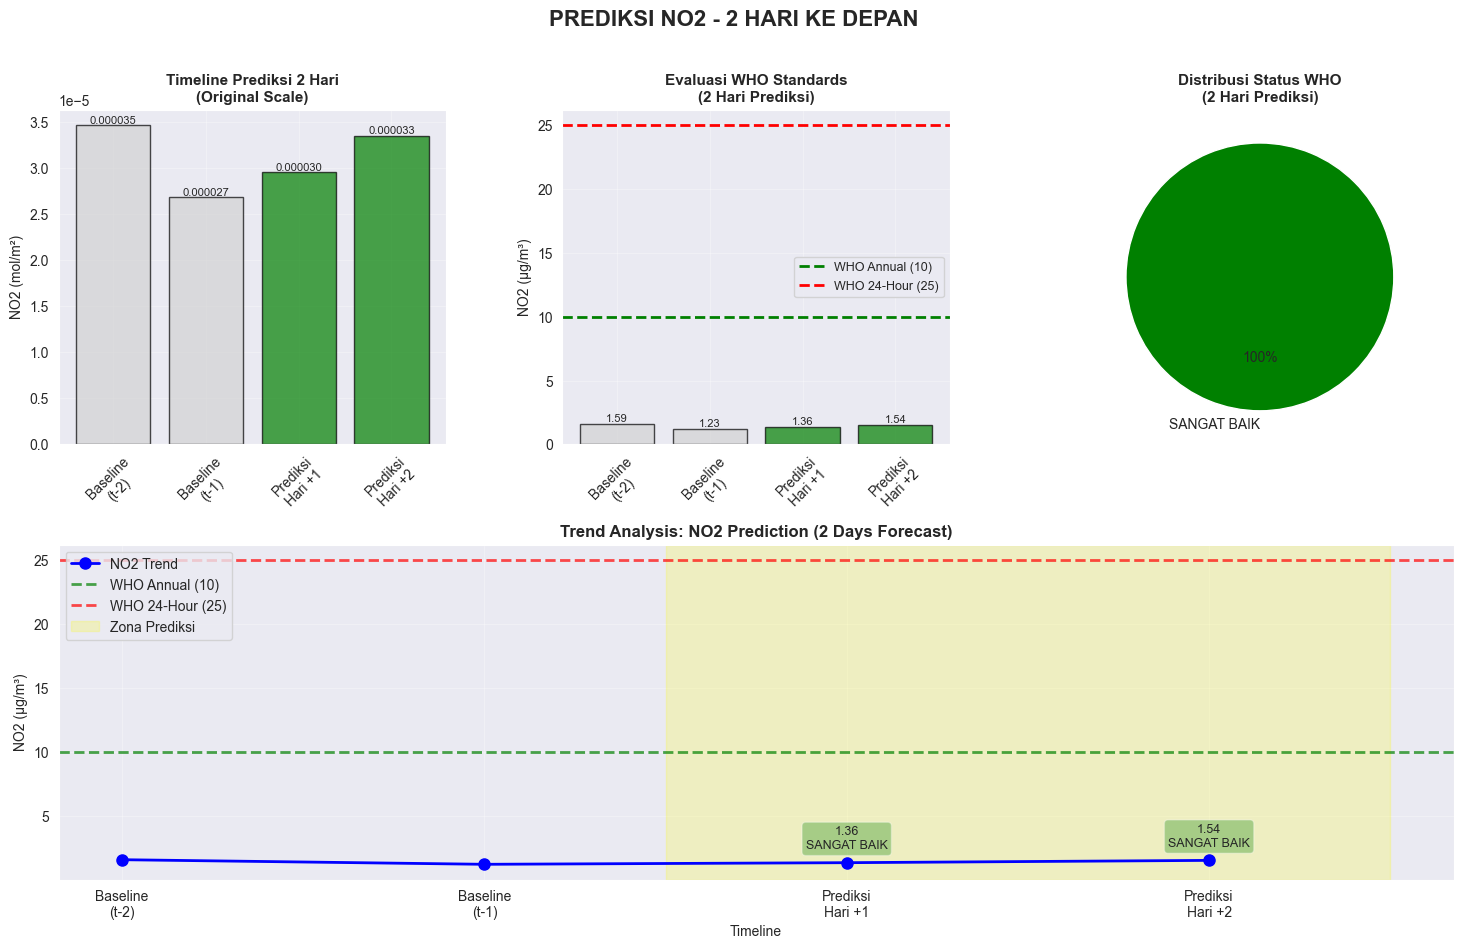


ANALISIS TREND:
Trend 2 hari: MENINGKAT ↗
Perubahan: +13.26%
Range prediksi: 1.36 - 1.54 µg/m³

Risk Assessment (2 hari):
  - Hari berisiko tinggi: 0/2
  - Hari perlu perhatian: 0/2
  - Hari aman: 2/2

PREDIKSI 2 HARI KE DEPAN SELESAI


In [23]:
# PREDIKSI 2 HARI KE DEPAN
print("=" * 60)
print("PREDIKSI 2 HARI KE DEPAN (MULTI-DAY FORECAST)")
print("=" * 60)

# Gunakan data terakhir dari supervised dataset sebagai titik awal
print("Menggunakan 2 hari terakhir dari data training sebagai baseline:")
baseline_data = supervised_df[["NO2(t-2)", "NO2(t-1)"]].iloc[-1].values
print(f"Baseline - NO2(t-2): {baseline_data[0]:.6f} mol/m²")
print(f"Baseline - NO2(t-1): {baseline_data[1]:.6f} mol/m²")

# Siapkan container untuk hasil prediksi
predictions = []
input_sequence = baseline_data.copy()

print(f"\n{'='*50}")
print("PROSES PREDIKSI ITERATIF:")
print(f"{'='*50}")

# Prediksi untuk 2 hari ke depan
for day in range(1, 3):  # Hari 1 dan Hari 2
    # Normalisasi input current
    input_scaled = scaler_deploy.transform([input_sequence])
    
    # Prediksi
    pred_mol = model_deploy.predict(input_scaled)[0]
    pred_ugm3 = pred_mol * CONVERSION_FACTOR
    
    # Evaluasi WHO status
    if pred_ugm3 <= WHO_ANNUAL:
        status = "SANGAT BAIK"
        status_color = 'green'
    elif pred_ugm3 <= WHO_24HOUR:
        status = "PERHATIAN"
        status_color = 'orange'
    else:
        status = "BERBAHAYA"
        status_color = 'red'
    
    print(f"\nHARI +{day}:")
    print(f"  Input: NO2(t-2)={input_sequence[0]:.6f}, NO2(t-1)={input_sequence[1]:.6f}")
    print(f"  Prediksi: {pred_mol:.6f} mol/m² = {pred_ugm3:.2f} µg/m³")
    print(f"  Status WHO: [{status}]")
    
    # Simpan hasil
    predictions.append({
        'day': day,
        'input_t2': input_sequence[0],
        'input_t1': input_sequence[1], 
        'predicted_mol': pred_mol,
        'predicted_ugm3': pred_ugm3,
        'who_status': status,
        'status_color': status_color
    })
    
    # Update sequence untuk prediksi berikutnya
    # Geser: t-1 menjadi t-2, prediksi menjadi t-1
    input_sequence = np.array([input_sequence[1], pred_mol])

print(f"\n{'='*50}")
print("RINGKASAN PREDIKSI 2 HARI:")
print(f"{'='*50}")

for pred in predictions:
    print(f"Hari +{pred['day']}: {pred['predicted_ugm3']:.2f} µg/m³ → {pred['who_status']}")

# VISUALISASI KOMPREHENSIF
fig = plt.figure(figsize=(18, 10))

# Layout: 2 baris, 3 kolom
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Timeline Lengkap (mol/m²)
ax1 = fig.add_subplot(gs[0, 0])
timeline_days = ['Baseline\n(t-2)', 'Baseline\n(t-1)', 'Prediksi\nHari +1', 'Prediksi\nHari +2']
timeline_values = [
    baseline_data[0], 
    baseline_data[1], 
    predictions[0]['predicted_mol'], 
    predictions[1]['predicted_mol']
]
timeline_colors = ['lightgray', 'lightgray', predictions[0]['status_color'], predictions[1]['status_color']]

bars1 = ax1.bar(timeline_days, timeline_values, color=timeline_colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('NO2 (mol/m²)')
ax1.set_title('Timeline Prediksi 2 Hari\n(Original Scale)', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

for bar, val in zip(bars1, timeline_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val:.6f}', ha='center', va='bottom', fontsize=8)

# Plot 2: WHO Comparison (µg/m³)
ax2 = fig.add_subplot(gs[0, 1])
timeline_ugm3 = [
    baseline_data[0] * CONVERSION_FACTOR,
    baseline_data[1] * CONVERSION_FACTOR,
    predictions[0]['predicted_ugm3'],
    predictions[1]['predicted_ugm3']
]

bars2 = ax2.bar(timeline_days, timeline_ugm3, color=timeline_colors, alpha=0.7, edgecolor='black')
ax2.axhline(WHO_ANNUAL, color='green', linestyle='--', linewidth=2, label=f'WHO Annual ({WHO_ANNUAL})')
ax2.axhline(WHO_24HOUR, color='red', linestyle='--', linewidth=2, label=f'WHO 24-Hour ({WHO_24HOUR})')
ax2.set_ylabel('NO2 (µg/m³)')
ax2.set_title('Evaluasi WHO Standards\n(2 Hari Prediksi)', fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

for bar, val in zip(bars2, timeline_ugm3):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{val:.2f}', ha='center', va='bottom', fontsize=8)

# Plot 3: Status Distribution
ax3 = fig.add_subplot(gs[0, 2])
status_counts = {}
for pred in predictions:
    status = pred['who_status']
    status_counts[status] = status_counts.get(status, 0) + 1

status_labels = list(status_counts.keys())
status_values = list(status_counts.values())
status_colors_pie = [predictions[i]['status_color'] for i in range(len(predictions)) if predictions[i]['who_status'] in status_labels]

# Jika ada status yang sama, ambil warna pertama
unique_colors = []
seen_status = []
for pred in predictions:
    if pred['who_status'] not in seen_status:
        unique_colors.append(pred['status_color'])
        seen_status.append(pred['who_status'])

wedges, texts, autotexts = ax3.pie(status_values, labels=status_labels, colors=unique_colors, 
                                   autopct='%1.0f%%', startangle=90)
ax3.set_title('Distribusi Status WHO\n(2 Hari Prediksi)', fontsize=11, fontweight='bold')

# Plot 4: Trend Analysis
ax4 = fig.add_subplot(gs[1, :])
x_axis = range(len(timeline_days))
ax4.plot(x_axis, timeline_ugm3, marker='o', linewidth=2, markersize=8, color='blue', label='NO2 Trend')
ax4.axhline(WHO_ANNUAL, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'WHO Annual ({WHO_ANNUAL})')
ax4.axhline(WHO_24HOUR, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'WHO 24-Hour ({WHO_24HOUR})')

# Highlight prediksi area
ax4.axvspan(1.5, 3.5, alpha=0.2, color='yellow', label='Zona Prediksi')

ax4.set_xticks(x_axis)
ax4.set_xticklabels(timeline_days)
ax4.set_ylabel('NO2 (µg/m³)')
ax4.set_xlabel('Timeline')
ax4.set_title('Trend Analysis: NO2 Prediction (2 Days Forecast)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Annotate trend
for i, (x, y) in enumerate(zip(x_axis, timeline_ugm3)):
    if i >= 2:  # Only for prediction days
        status = predictions[i-2]['who_status']
        ax4.annotate(f'{y:.2f}\n{status}', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor=predictions[i-2]['status_color'], alpha=0.3))

plt.suptitle('PREDIKSI NO2 - 2 HARI KE DEPAN', fontsize=16, fontweight='bold')
plt.show()

print(f"\n{'='*60}")
print("ANALISIS TREND:")
print(f"{'='*60}")

# Analisis trend
if predictions[1]['predicted_ugm3'] > predictions[0]['predicted_ugm3']:
    trend = "MENINGKAT"
    trend_symbol = "↗"
elif predictions[1]['predicted_ugm3'] < predictions[0]['predicted_ugm3']:
    trend = "MENURUN" 
    trend_symbol = "↘"
else:
    trend = "STABIL"
    trend_symbol = "→"

change_rate = ((predictions[1]['predicted_ugm3'] - predictions[0]['predicted_ugm3']) / predictions[0]['predicted_ugm3']) * 100

print(f"Trend 2 hari: {trend} {trend_symbol}")
print(f"Perubahan: {change_rate:+.2f}%")
print(f"Range prediksi: {min(p['predicted_ugm3'] for p in predictions):.2f} - {max(p['predicted_ugm3'] for p in predictions):.2f} µg/m³")

# Risk Assessment
high_risk_days = sum(1 for p in predictions if p['who_status'] == 'BERBAHAYA')
medium_risk_days = sum(1 for p in predictions if p['who_status'] == 'PERHATIAN')
low_risk_days = sum(1 for p in predictions if p['who_status'] == 'SANGAT BAIK')

print(f"\nRisk Assessment (2 hari):")
print(f"  - Hari berisiko tinggi: {high_risk_days}/2")
print(f"  - Hari perlu perhatian: {medium_risk_days}/2") 
print(f"  - Hari aman: {low_risk_days}/2")

print(f"\n{'='*60}")
print("PREDIKSI 2 HARI KE DEPAN SELESAI")
print(f"{'='*60}")